In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder,OneHotEncoder # for encoding categorical variables


In [4]:
churn = pd.read_csv('/content/drive/MyDrive/DATA/Telco-Customer-Churn.csv')


In [5]:
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [7]:
churn.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


## Exploratory Data Analysis


## General Feature Exploration

In [8]:
categ_cols = churn.select_dtypes(include=['object', 'category']).columns

# num column == numerical columns + date column included
num_cols = [col for col in churn.columns if col not in categ_cols]
print(f'The Categorical Columns are: {categ_cols}')
print(f'The Numerical Columns are: {num_cols}')

The Categorical Columns are: Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')
The Numerical Columns are: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [9]:
churn.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

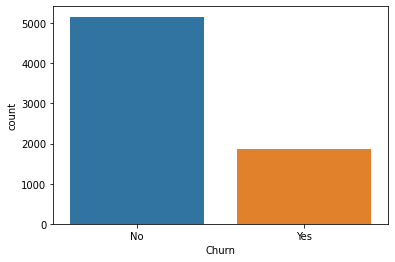

In [10]:
sns.countplot(data = churn, x='Churn' )

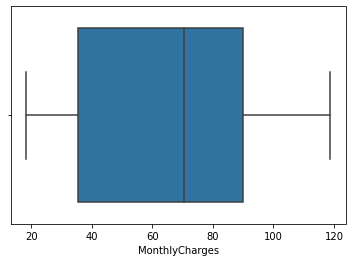

In [11]:
sns.boxplot(data=churn,x='MonthlyCharges')

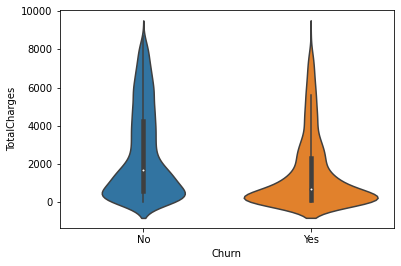

In [12]:
sns.violinplot(data=churn,x='Churn',y='TotalCharges');

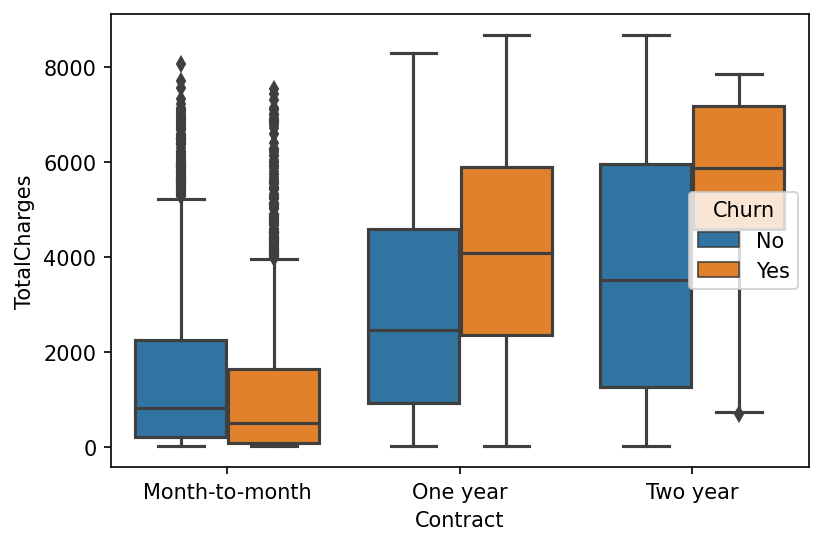

In [13]:
plt.figure(figsize=(6,4),dpi=150)

sns.boxplot(data=churn,x='Contract',y='TotalCharges',hue='Churn');

People who have more years of contract have a higher charges which is expected 

In [14]:
churn_pay=churn.loc[churn['TotalCharges']>6500]

In [15]:
corr_churn  = pd.get_dummies(churn[['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod','Churn']],drop_first=True).corr()                             

In [16]:
corr_churn['Churn_Yes'].sort_values().iloc[1:-1]

StreamingMovies_No internet service     -0.227578
StreamingTV_No internet service         -0.227578
TechSupport_No internet service         -0.227578
OnlineSecurity_No internet service      -0.227578
InternetService_No                      -0.227578
DeviceProtection_No internet service    -0.227578
OnlineBackup_No internet service        -0.227578
Contract_One year                       -0.178225
OnlineSecurity_Yes                      -0.171270
TechSupport_Yes                         -0.164716
Dependents_Yes                          -0.163128
Partner_Yes                             -0.149982
PaymentMethod_Credit card (automatic)   -0.134687
PaymentMethod_Mailed check              -0.090773
OnlineBackup_Yes                        -0.082307
DeviceProtection_Yes                    -0.066193
MultipleLines_No phone service          -0.011691
gender_Male                             -0.008545
PhoneService_Yes                         0.011691
MultipleLines_Yes                        0.040033


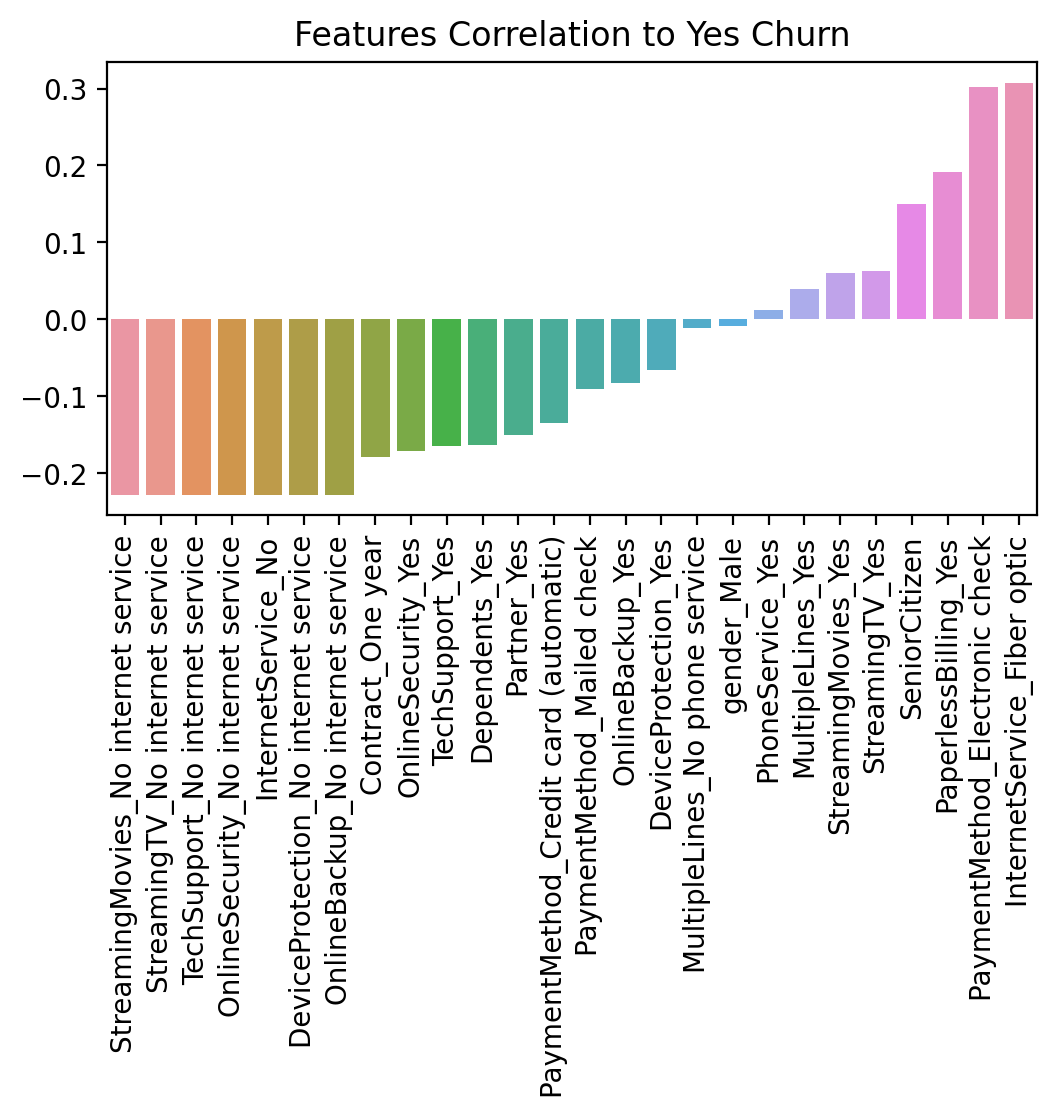

In [17]:
plt.figure(figsize=(6,3),dpi=200)
sns.barplot(x=corr_churn['Churn_Yes'].sort_values().iloc[1:-1].index,y=corr_churn['Churn_Yes'].sort_values().iloc[1:-1].values)
plt.title("Features Correlation to Yes Churn")
plt.xticks(rotation=90);

## Churn Analysis

This section focuses on segementing customers based on their tenure, creating "cohorts".

In [18]:
churn['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

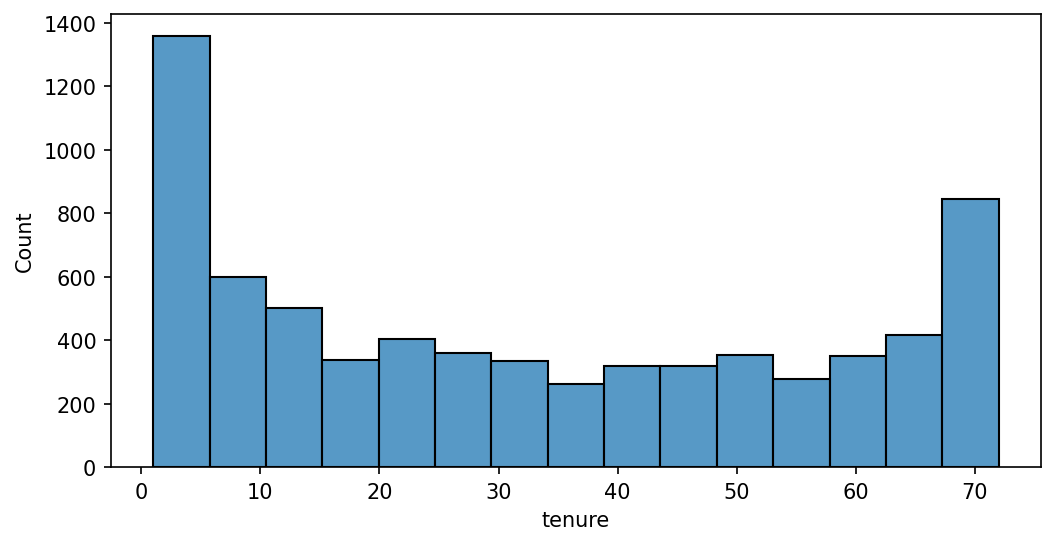

In [19]:
plt.figure(figsize =(8,4),dpi=150)
sns.histplot(data=churn,x='tenure');

<Figure size 2000x600 with 0 Axes>

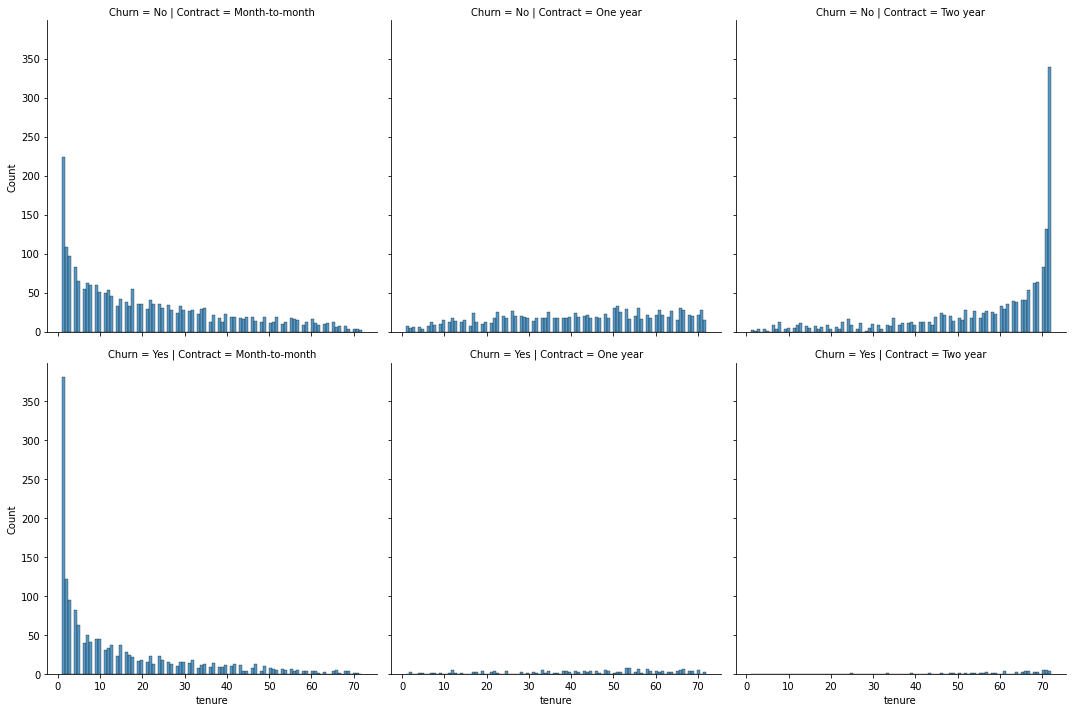

In [20]:
plt.figure(figsize=(10,3),dpi=200)
sns.displot(data=churn,x='tenure',bins=100,col='Contract',row='Churn');

In [21]:
churn.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

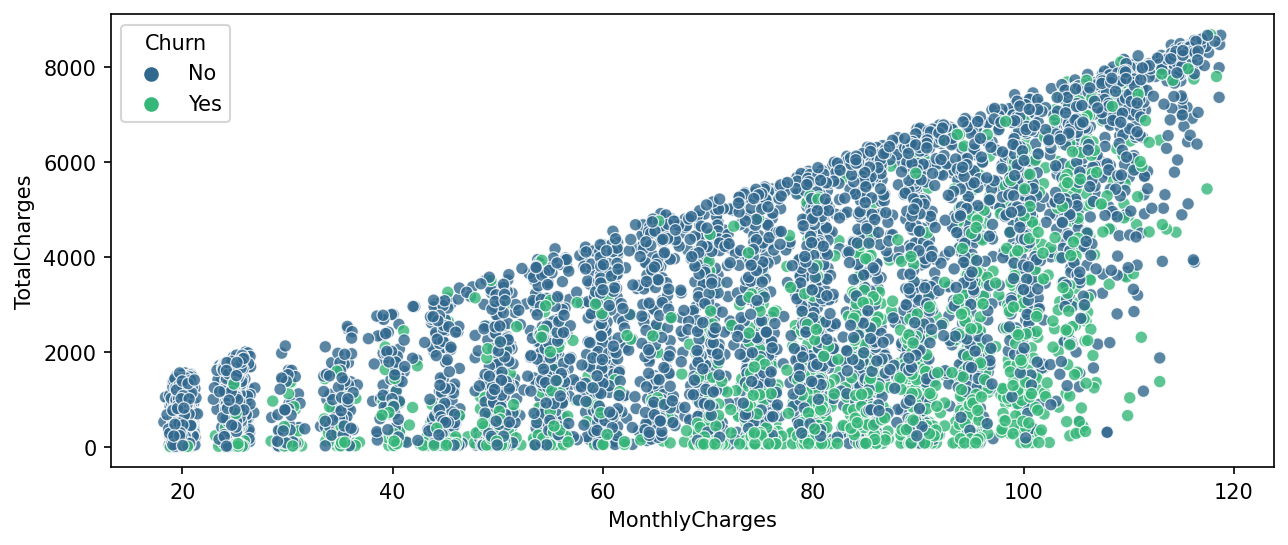

In [22]:
plt.figure(figsize=(10,4),dpi=150)
sns.scatterplot(data=churn,x='MonthlyCharges',y='TotalCharges',hue='Churn',linewidth=0.6,alpha=0.8,palette='viridis');

In [23]:
no_churn = churn.groupby(['Churn','tenure']).count().transpose()['No']
yes_churn = churn.groupby(['Churn','tenure']).count().transpose()['Yes']

In [24]:
churn_rate = 100 * yes_churn / (no_churn+yes_churn)

In [25]:
customer_rate =churn_rate.transpose()['customerID']

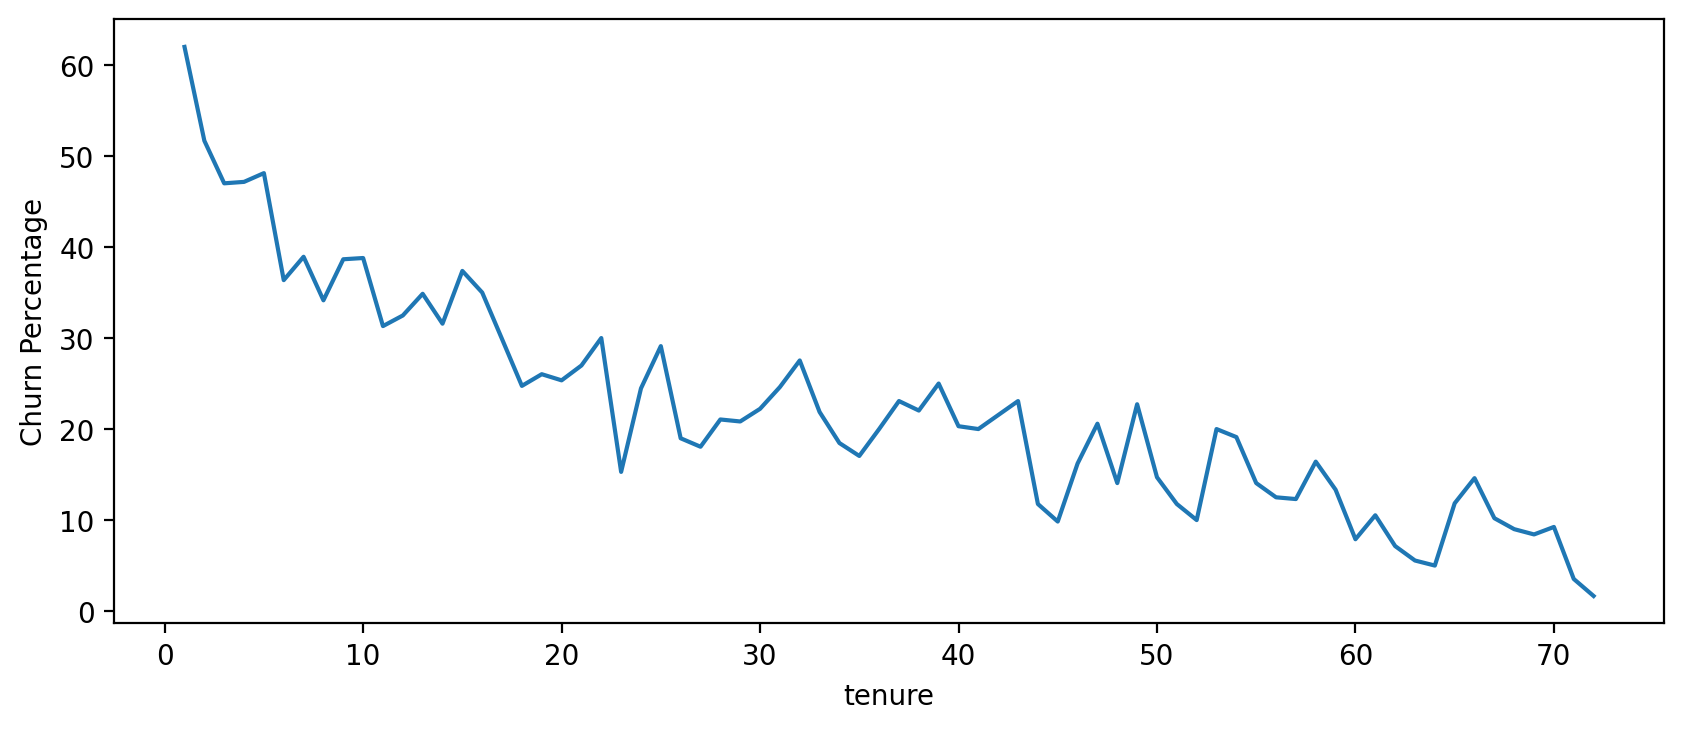

In [26]:
plt.figure(figsize=(10,4),dpi=200)
churn_rate.iloc[0].plot()
plt.ylabel('Churn Percentage');

## Feature Engineering

In [27]:
# to seperate the tenure into months/years
def cohort(tenure):
    if tenure < 13:
        return '0-12 Months'
    elif tenure < 25:
        return '12-24 Months'
    elif tenure < 49:
        return '24-48 Months'
    else:
        return "Over 48 Months"

churn['Tenure_Cohort'] = churn['tenure'].apply(cohort)

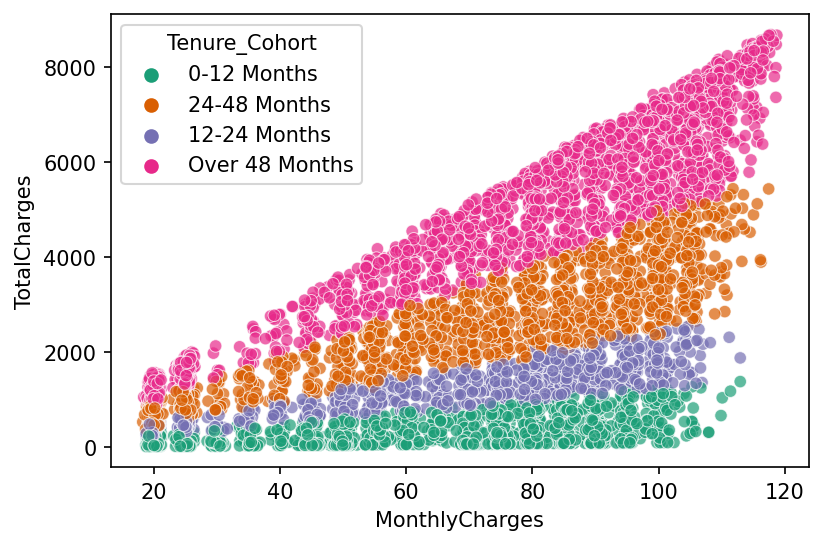

In [28]:
# scatter plot of the charges paid mothly/yearly
plt.figure(figsize=(6,4),dpi=150)
sns.scatterplot(x='MonthlyCharges',y='TotalCharges',data=churn,hue='Tenure_Cohort',palette='Dark2',alpha=0.7)

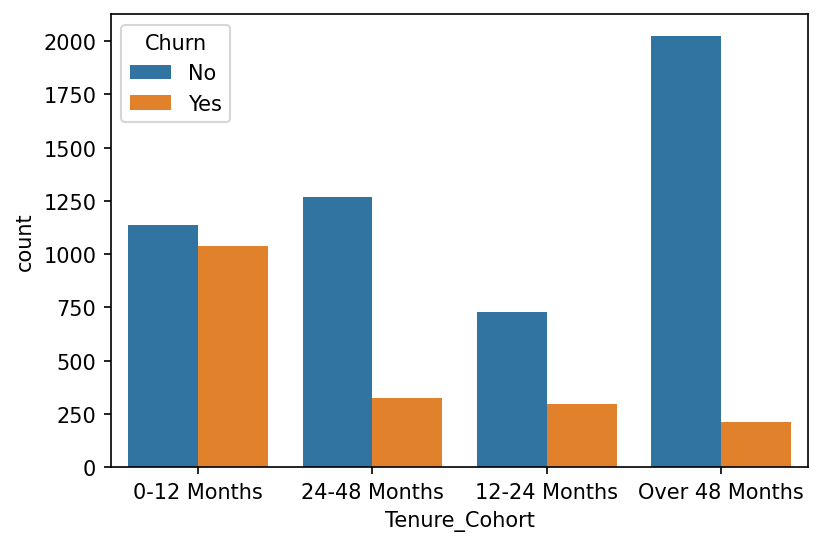

In [29]:
#count plot to show the duration in months before churn
plt.figure(figsize=(6,4),dpi=150)
sns.countplot(data=churn,x='Tenure_Cohort',hue='Churn')

Churn is higher in month 0-12 moths than in every other months

<Figure size 1200x800 with 0 Axes>

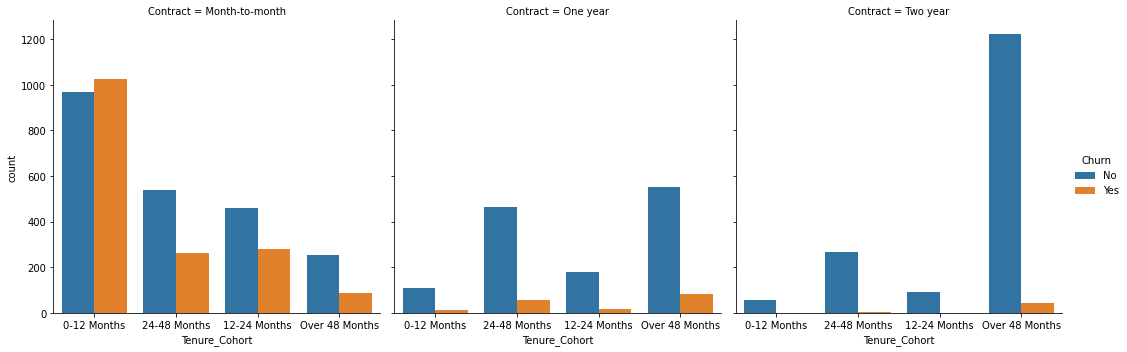

In [30]:
plt.figure(figsize=(6,4),dpi=200)
sns.catplot(data=churn,x='Tenure_Cohort',hue='Churn',col='Contract',kind='count');

In [31]:
churn['TotalCharges'].sort_values()

1649      18.80
6480      18.85
1147      18.85
4931      18.90
582       19.00
         ...   
2182    8564.75
5338    8594.40
6757    8670.10
4578    8672.45
4602    8684.80
Name: TotalCharges, Length: 7032, dtype: float64

In [32]:
# To Normalize the total charges column
def Charges(TotalCharges):
  """
   Description: Function to normalize the total charges column

    Arguments: It takes in the total charges column as an arugmnet
    """
  if TotalCharges <= 500:
    return 0
  elif TotalCharges <= 1000:
    return 1
  elif TotalCharges <= 2000:
    return 2
  elif TotalCharges <= 3000:
    return 3
  elif TotalCharges <= 4000:
    return 4
  elif TotalCharges <= 5000:
    return 5
  elif TotalCharges <= 6000:
    return 6
  elif TotalCharges <= 7000:
    return 7
  else:
    return 8
churn['charges'] = churn['TotalCharges'].apply(Charges)


In [33]:
poly_features = ['MonthlyCharges','TotalCharges']


In [34]:
from sklearn.preprocessing import PolynomialFeatures

In [35]:
# using the sklearn polynomial features to create a new feature from monthlyCharges and totalcharges
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

poly1 = poly.fit_transform(churn[poly_features])

In [36]:
df_poly1 = pd.DataFrame(poly1, columns=[f"poly1_{i}" for i in range(poly1.shape[1])])

In [37]:
data = pd.concat([churn, df_poly1], axis = 1)

In [38]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'Tenure_Cohort', 'charges', 'poly1_0', 'poly1_1', 'poly1_2'],
      dtype='object')

In [39]:
data.select_dtypes(include=['int64','float64']).columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'charges',
       'poly1_0', 'poly1_1', 'poly1_2'],
      dtype='object')

## Encoding Categorical Variables

In [40]:
categ_cols

Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

In [41]:
# label encoding.
#used the get dummy but the model was giving me a low performance, label encoding encoding was giving me a better performance. 
#le = LabelEncoder()
#for i in categ_cols:
 # data[i] = le.fit_transform(data[i])
  
#data.head()


In [42]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'Tenure_Cohort', 'charges', 'poly1_0', 'poly1_1', 'poly1_2'],
      dtype='object')

In [43]:
churn.shape

(7032, 23)

In [44]:
data.shape

(7032, 26)

In [45]:
X = data.drop(['Churn','customerID','Tenure_Cohort'],axis = 1)
X = pd.get_dummies(X,drop_first=True)
y= data['Churn']


## Predictive Modeling

In [48]:
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.metrics import log_loss, f1_score
from sklearn.metrics import accuracy_score,plot_confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from catboost import CatBoostClassifier

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [50]:
def report_model(model):
  
  
  """
   Description: Function to print the performance of the models

    Arguments: models
    """
  model_preds = model.predict(X_test)
  print(classification_report(y_test,model_preds))
  print('\n') 
  plot_confusion_matrix(dt,X_test,y_test)
    

## Models

In [51]:
#!pip install catboost --quiet

## Base Model

In [52]:
dt =  DecisionTreeClassifier(max_depth=10,min_samples_leaf=50)

In [53]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50)

              precision    recall  f1-score   support

          No       0.84      0.89      0.87      1052
         Yes       0.61      0.52      0.56       355

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.79      0.79      0.79      1407





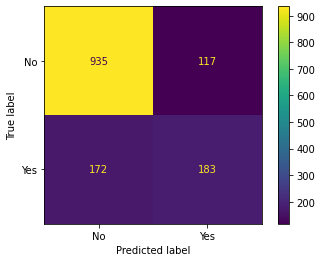

In [54]:
report_model(dt)

In [55]:
imp_feats = pd.DataFrame(data=dt.feature_importances_,index=X.columns,columns=['Feature Importance']).sort_values("Feature Importance")


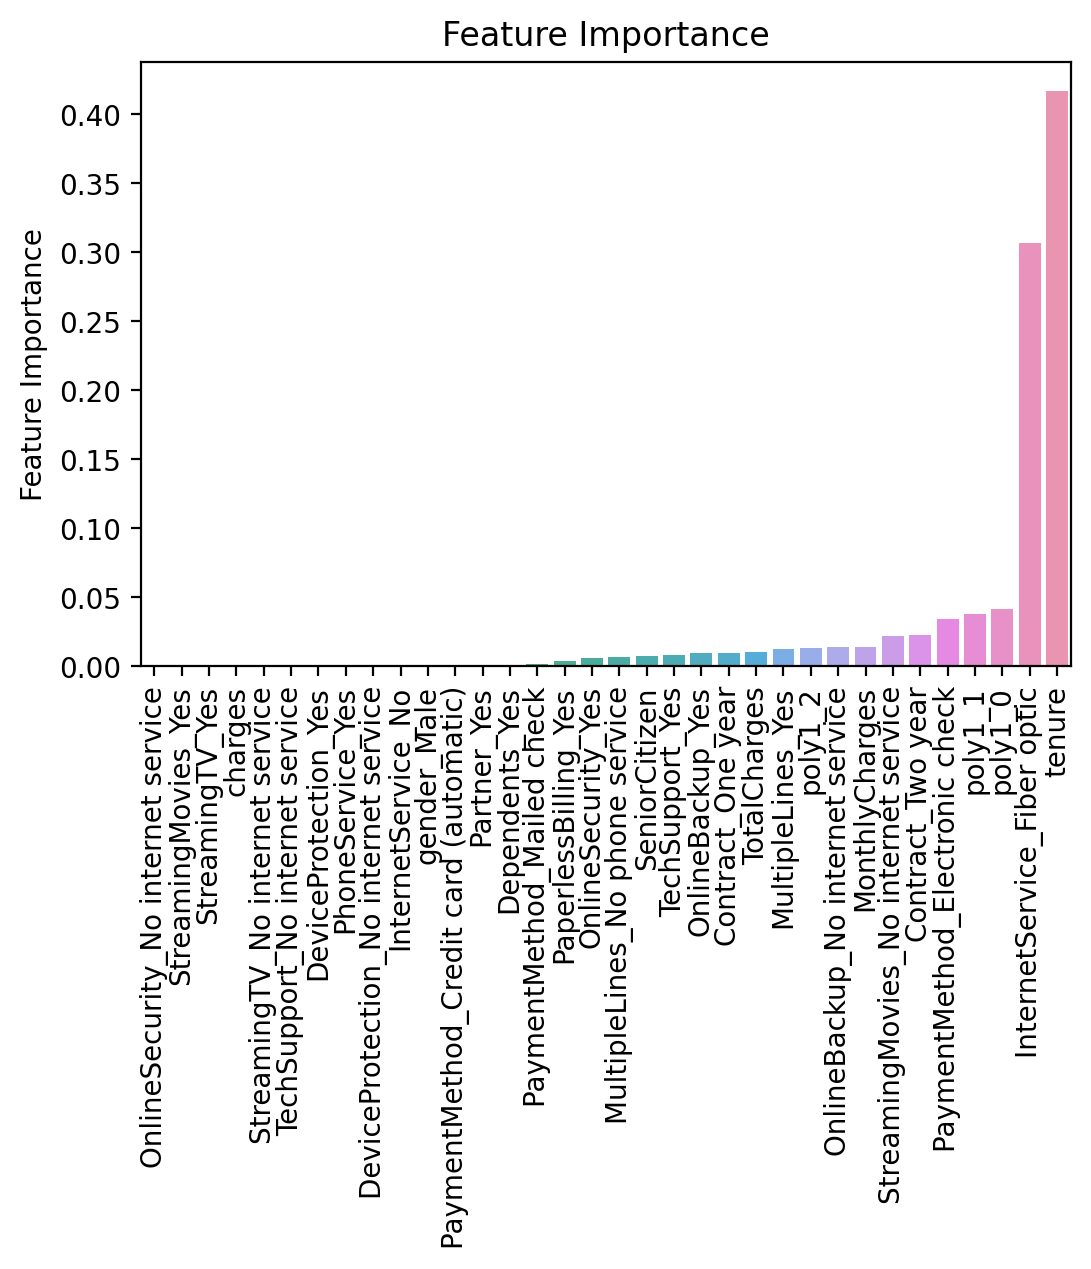

In [56]:
plt.figure(figsize=(6,4),dpi=200)
sns.barplot(data=imp_feats.sort_values('Feature Importance'),x=imp_feats.sort_values('Feature Importance').index,y='Feature Importance')
plt.xticks(rotation=90)
plt.title("Feature Importance");

In [57]:
# Random Forest 
rf = RandomForestClassifier(n_estimators=80,random_state=0)

In [58]:
 rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=80, random_state=0)

              precision    recall  f1-score   support

          No       0.84      0.89      0.86      1052
         Yes       0.60      0.50      0.55       355

    accuracy                           0.79      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407





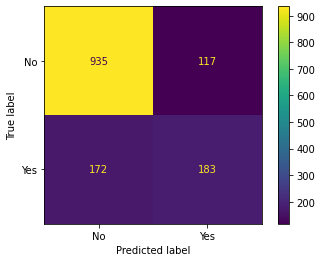

In [59]:
report_model(rf)

In [60]:
# Ada boost
ab =AdaBoostClassifier(n_estimators=100,random_state=0)

In [61]:
ab.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

              precision    recall  f1-score   support

          No       0.85      0.90      0.88      1052
         Yes       0.65      0.54      0.59       355

    accuracy                           0.81      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.80      0.81      0.80      1407





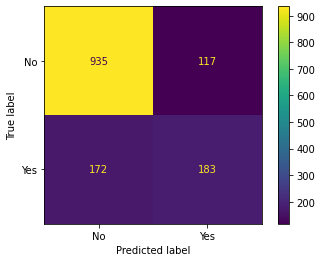

In [62]:
report_model(ab)

In [63]:
# GradientBoostingClassifier
#n_estimator default for GradientBoostingClassifier is 100
grb = GradientBoostingClassifier()

In [64]:
grb.fit(X_train,y_train)

GradientBoostingClassifier()

              precision    recall  f1-score   support

          No       0.85      0.90      0.88      1052
         Yes       0.65      0.52      0.58       355

    accuracy                           0.81      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.80      0.81      0.80      1407





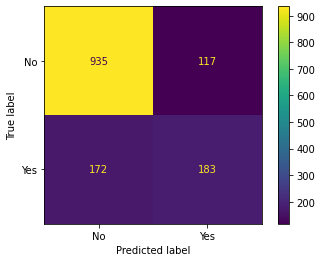

In [65]:
report_model(grb)

In [66]:
cat_model=CatBoostClassifier()

In [67]:
cat_model.fit(X_train,y_train)

Learning rate set to 0.02154
0:	learn: 0.6791571	total: 52.4ms	remaining: 52.4s
1:	learn: 0.6641977	total: 56.1ms	remaining: 28s
2:	learn: 0.6506732	total: 59.4ms	remaining: 19.7s
3:	learn: 0.6391229	total: 62.6ms	remaining: 15.6s
4:	learn: 0.6282914	total: 66ms	remaining: 13.1s
5:	learn: 0.6161364	total: 69.4ms	remaining: 11.5s
6:	learn: 0.6061022	total: 72.7ms	remaining: 10.3s
7:	learn: 0.5972714	total: 76.1ms	remaining: 9.43s
8:	learn: 0.5891746	total: 79.4ms	remaining: 8.74s
9:	learn: 0.5805387	total: 83.6ms	remaining: 8.28s
10:	learn: 0.5722850	total: 87.4ms	remaining: 7.86s
11:	learn: 0.5651039	total: 90.7ms	remaining: 7.46s
12:	learn: 0.5583951	total: 94ms	remaining: 7.14s
13:	learn: 0.5519775	total: 97.6ms	remaining: 6.88s
14:	learn: 0.5460092	total: 101ms	remaining: 6.65s
15:	learn: 0.5403802	total: 105ms	remaining: 6.43s
16:	learn: 0.5342057	total: 108ms	remaining: 6.25s
17:	learn: 0.5281185	total: 112ms	remaining: 6.09s
18:	learn: 0.5232159	total: 116ms	remaining: 5.98s
19:	

              precision    recall  f1-score   support

          No       0.85      0.90      0.88      1052
         Yes       0.65      0.54      0.59       355

    accuracy                           0.81      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.80      0.81      0.80      1407





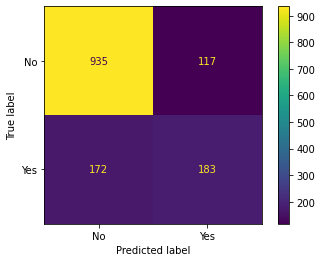

In [68]:
report_model(cat_model)

In [69]:
!pip install optuna --quiet
 


     |████████████████████████████████| 308 kB 13.3 MB/s 
     |████████████████████████████████| 209 kB 49.2 MB/s 
     |████████████████████████████████| 80 kB 6.2 MB/s 
     |████████████████████████████████| 75 kB 3.3 MB/s 
     |████████████████████████████████| 112 kB 77.9 MB/s 
     |████████████████████████████████| 49 kB 4.2 MB/s 
     |████████████████████████████████| 149 kB 56.4 MB/s 


In [70]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'Tenure_Cohort', 'charges', 'poly1_0', 'poly1_1', 'poly1_2'],
      dtype='object')

In [71]:
import optuna

In [72]:
def objective(trial):
    oof_f1=[]
    oof_predictions=[]


    param = {}
#     param['objective'] = "Logloss"
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.01, 0.1, 0.001)
    param['depth'] = trial.suggest_int('depth', 3, 15)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['iterations'] = trial.suggest_discrete_uniform("iterations", 200, 2000, 50)
    param['use_best_model'] = True
    param["colsample_bylevel"] =  trial.suggest_float("colsample_bylevel", 0.01, 0.1)
    param['random_state'] = 0
    param['scale_pos_weight'] = trial.suggest_int('scale_pos_weight', 1, 10)
    param['bootstrap_type'] = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    param['logging_level'] = 'Silent'



    fold=StratifiedKFold(n_splits=5)#15#5#10
    i=1
    for train_index, test_index in fold.split(X,y):
      print("Train Index: ", train_index, "\n")
      print("Test Index: ", test_index)
      X_train, X_test, y_train, y_test = X.iloc[train_index,:], X.iloc[test_index,:], y.iloc[train_index], y.iloc[test_index]
      model = CatBoostClassifier(**param)
      
      model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=200, verbose = False)#erly100
      preds=model.predict(X_test)
      #p2 = model.predict_proba([X_test.columns])[:, -1]

      oof_f1.append(accuracy_score(y_test,preds))
        
    

    return np.mean(oof_f1)

In [73]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)

[I 2021-12-26 00:09:38,013] A new study created in memory with name: no-name-3788c746-8c7c-4cee-9317-dd246bfaf525


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:09:47,952] Trial 0 finished with value: 0.691263859527803 and parameters: {'learning_rate': 0.079, 'depth': 11, 'l2_leaf_reg': 3.5, 'min_child_samples': 1, 'iterations': 350.0, 'colsample_bylevel': 0.0711412738644001, 'scale_pos_weight': 5, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.691263859527803.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:09:54,377] Trial 1 finished with value: 0.6305371132551022 and parameters: {'learning_rate': 0.074, 'depth': 12, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 900.0, 'colsample_bylevel': 0.051176176695086464, 'scale_pos_weight': 8, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.691263859527803.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:09:58,277] Trial 2 finished with value: 0.6153258297013207 and parameters: {'learning_rate': 0.09, 'depth': 11, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 600.0, 'colsample_bylevel': 0.029078341004146656, 'scale_pos_weight': 9, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.691263859527803.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:12:06,296] Trial 3 finished with value: 0.7554018163601823 and parameters: {'learning_rate': 0.069, 'depth': 15, 'l2_leaf_reg': 2.0, 'min_child_samples': 4, 'iterations': 200.0, 'colsample_bylevel': 0.09812491204934982, 'scale_pos_weight': 3, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.7554018163601823.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:12:27,556] Trial 4 finished with value: 0.7460160081526931 and parameters: {'learning_rate': 0.088, 'depth': 15, 'l2_leaf_reg': 1.0, 'min_child_samples': 1, 'iterations': 1200.0, 'colsample_bylevel': 0.062071733802595855, 'scale_pos_weight': 3, 'bootstrap_type': 'MVS'}. Best is trial 3 with value: 0.7554018163601823.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:12:37,264] Trial 5 finished with value: 0.7380533827509475 and parameters: {'learning_rate': 0.053000000000000005, 'depth': 14, 'l2_leaf_reg': 1.5, 'min_child_samples': 1, 'iterations': 1450.0, 'colsample_bylevel': 0.010626916693860575, 'scale_pos_weight': 3, 'bootstrap_type': 'Bernoulli'}. Best is trial 3 with value: 0.7554018163601823.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:12:51,074] Trial 6 finished with value: 0.6848665633426042 and parameters: {'learning_rate': 0.01, 'depth': 7, 'l2_leaf_reg': 4.0, 'min_child_samples': 4, 'iterations': 1350.0, 'colsample_bylevel': 0.044571575593373436, 'scale_pos_weight': 5, 'bootstrap_type': 'MVS'}. Best is trial 3 with value: 0.7554018163601823.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:12:54,774] Trial 7 finished with value: 0.639217547701444 and parameters: {'learning_rate': 0.097, 'depth': 5, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'iterations': 1900.0, 'colsample_bylevel': 0.048169177313889214, 'scale_pos_weight': 7, 'bootstrap_type': 'MVS'}. Best is trial 3 with value: 0.7554018163601823.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:12:59,888] Trial 8 finished with value: 0.691263151828745 and parameters: {'learning_rate': 0.086, 'depth': 9, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 1300.0, 'colsample_bylevel': 0.05107793471152634, 'scale_pos_weight': 5, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.7554018163601823.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:13:12,824] Trial 9 finished with value: 0.5907261093435483 and parameters: {'learning_rate': 0.01, 'depth': 11, 'l2_leaf_reg': 3.0, 'min_child_samples': 4, 'iterations': 400.0, 'colsample_bylevel': 0.08226333011223234, 'scale_pos_weight': 10, 'bootstrap_type': 'Bernoulli'}. Best is trial 3 with value: 0.7554018163601823.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:13:18,293] Trial 10 finished with value: 0.8056014380444859 and parameters: {'learning_rate': 0.047, 'depth': 3, 'l2_leaf_reg': 2.5, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.09814737221261126, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.8056014380444859.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:13:23,998] Trial 11 finished with value: 0.8067394181298345 and parameters: {'learning_rate': 0.049, 'depth': 3, 'l2_leaf_reg': 2.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.09588051195958086, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.8067394181298345.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:13:30,049] Trial 12 finished with value: 0.8034688374829774 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 2.5, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.09932369416002207, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.8067394181298345.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:13:37,548] Trial 13 finished with value: 0.8083041407471887 and parameters: {'learning_rate': 0.031, 'depth': 3, 'l2_leaf_reg': 2.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.08459804012079322, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:13:44,345] Trial 14 finished with value: 0.8036103772945878 and parameters: {'learning_rate': 0.031, 'depth': 5, 'l2_leaf_reg': 4.0, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.08122004301255055, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:13:51,128] Trial 15 finished with value: 0.7809989879903471 and parameters: {'learning_rate': 0.028999999999999998, 'depth': 5, 'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'iterations': 1750.0, 'colsample_bylevel': 0.08440384612304448, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:13:56,210] Trial 16 finished with value: 0.7131648200776245 and parameters: {'learning_rate': 0.063, 'depth': 7, 'l2_leaf_reg': 3.0, 'min_child_samples': 8, 'iterations': 600.0, 'colsample_bylevel': 0.07441399294509216, 'scale_pos_weight': 4, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:14:04,033] Trial 17 finished with value: 0.6397872454431763 and parameters: {'learning_rate': 0.027000000000000003, 'depth': 3, 'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.08784719283970169, 'scale_pos_weight': 7, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:14:10,319] Trial 18 finished with value: 0.7792931299608441 and parameters: {'learning_rate': 0.039, 'depth': 7, 'l2_leaf_reg': 4.0, 'min_child_samples': 8, 'iterations': 1550.0, 'colsample_bylevel': 0.06425159468046064, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:14:15,353] Trial 19 finished with value: 0.7798627266027109 and parameters: {'learning_rate': 0.059000000000000004, 'depth': 4, 'l2_leaf_reg': 3.5, 'min_child_samples': 8, 'iterations': 600.0, 'colsample_bylevel': 0.08883692752505291, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:14:24,280] Trial 20 finished with value: 0.7138763609305636 and parameters: {'learning_rate': 0.02, 'depth': 8, 'l2_leaf_reg': 2.5, 'min_child_samples': 32, 'iterations': 1150.0, 'colsample_bylevel': 0.07206890518304178, 'scale_pos_weight': 4, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:14:30,556] Trial 21 finished with value: 0.8075924987943841 and parameters: {'learning_rate': 0.048, 'depth': 3, 'l2_leaf_reg': 2.5, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.09612876905722177, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:14:35,314] Trial 22 finished with value: 0.8070237109514407 and parameters: {'learning_rate': 0.049, 'depth': 4, 'l2_leaf_reg': 3.0, 'min_child_samples': 8, 'iterations': 750.0, 'colsample_bylevel': 0.09311821089534843, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:14:40,653] Trial 23 finished with value: 0.7811423475995354 and parameters: {'learning_rate': 0.038, 'depth': 5, 'l2_leaf_reg': 3.0, 'min_child_samples': 8, 'iterations': 700.0, 'colsample_bylevel': 0.09099216893877782, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:14:44,867] Trial 24 finished with value: 0.8060277761770299 and parameters: {'learning_rate': 0.057, 'depth': 4, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 450.0, 'colsample_bylevel': 0.07838631208083333, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:14:53,430] Trial 25 finished with value: 0.7447372970546576 and parameters: {'learning_rate': 0.019000000000000003, 'depth': 6, 'l2_leaf_reg': 3.5, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.09224411929024694, 'scale_pos_weight': 3, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:14:59,443] Trial 26 finished with value: 0.7792930288609785 and parameters: {'learning_rate': 0.045000000000000005, 'depth': 4, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'iterations': 700.0, 'colsample_bylevel': 0.03780261390693785, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:15:06,246] Trial 27 finished with value: 0.7153000492356345 and parameters: {'learning_rate': 0.034, 'depth': 6, 'l2_leaf_reg': 3.0, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.06379157866427337, 'scale_pos_weight': 4, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:15:13,934] Trial 28 finished with value: 0.8027577010295 and parameters: {'learning_rate': 0.065, 'depth': 9, 'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'iterations': 500.0, 'colsample_bylevel': 0.07644386253001938, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:15:16,548] Trial 29 finished with value: 0.6277012620296202 and parameters: {'learning_rate': 0.023, 'depth': 4, 'l2_leaf_reg': 3.5, 'min_child_samples': 1, 'iterations': 200.0, 'colsample_bylevel': 0.06762611865085012, 'scale_pos_weight': 6, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:15:21,515] Trial 30 finished with value: 0.783559645382112 and parameters: {'learning_rate': 0.052000000000000005, 'depth': 6, 'l2_leaf_reg': 1.5, 'min_child_samples': 4, 'iterations': 1150.0, 'colsample_bylevel': 0.0846546859143139, 'scale_pos_weight': 2, 'bootstrap_type': 'Bernoulli'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:15:27,869] Trial 31 finished with value: 0.8058857308660923 and parameters: {'learning_rate': 0.048, 'depth': 3, 'l2_leaf_reg': 2.5, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.09544323384324259, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:15:33,059] Trial 32 finished with value: 0.805317448522476 and parameters: {'learning_rate': 0.075, 'depth': 3, 'l2_leaf_reg': 2.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09265773112173681, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:15:40,577] Trial 33 finished with value: 0.7788660841292421 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 4, 'l2_leaf_reg': 3.0, 'min_child_samples': 16, 'iterations': 850.0, 'colsample_bylevel': 0.0873080670174039, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:15:45,296] Trial 34 finished with value: 0.7408969175662026 and parameters: {'learning_rate': 0.053000000000000005, 'depth': 3, 'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'iterations': 700.0, 'colsample_bylevel': 0.099609741282816, 'scale_pos_weight': 3, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:15:53,269] Trial 35 finished with value: 0.8026156557185622 and parameters: {'learning_rate': 0.042, 'depth': 12, 'l2_leaf_reg': 2.5, 'min_child_samples': 16, 'iterations': 300.0, 'colsample_bylevel': 0.056770125352327026, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:15:57,687] Trial 36 finished with value: 0.7407542656560724 and parameters: {'learning_rate': 0.071, 'depth': 4, 'l2_leaf_reg': 1.5, 'min_child_samples': 8, 'iterations': 550.0, 'colsample_bylevel': 0.09406668584734224, 'scale_pos_weight': 3, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:16:06,914] Trial 37 finished with value: 0.7782967907869713 and parameters: {'learning_rate': 0.063, 'depth': 5, 'l2_leaf_reg': 3.5, 'min_child_samples': 1, 'iterations': 1250.0, 'colsample_bylevel': 0.01803815027944554, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:16:11,782] Trial 38 finished with value: 0.7097535084180804 and parameters: {'learning_rate': 0.049, 'depth': 3, 'l2_leaf_reg': 3.0, 'min_child_samples': 32, 'iterations': 700.0, 'colsample_bylevel': 0.09474000565793939, 'scale_pos_weight': 4, 'bootstrap_type': 'Bernoulli'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:16:16,748] Trial 39 finished with value: 0.6282650959791571 and parameters: {'learning_rate': 0.058, 'depth': 6, 'l2_leaf_reg': 2.5, 'min_child_samples': 4, 'iterations': 950.0, 'colsample_bylevel': 0.07945584656712026, 'scale_pos_weight': 8, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:16:22,056] Trial 40 finished with value: 0.7397594429801815 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 4, 'l2_leaf_reg': 2.0, 'min_child_samples': 1, 'iterations': 1050.0, 'colsample_bylevel': 0.08688842375398559, 'scale_pos_weight': 3, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:16:26,404] Trial 41 finished with value: 0.8044632557594067 and parameters: {'learning_rate': 0.059000000000000004, 'depth': 4, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 450.0, 'colsample_bylevel': 0.07813951049418608, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:16:29,940] Trial 42 finished with value: 0.805175099911942 and parameters: {'learning_rate': 0.055, 'depth': 5, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 300.0, 'colsample_bylevel': 0.07139523756597156, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:16:40,789] Trial 43 finished with value: 0.8047477507807438 and parameters: {'learning_rate': 0.049, 'depth': 10, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 850.0, 'colsample_bylevel': 0.09076863617765155, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:17:48,151] Trial 44 finished with value: 0.7838425228056021 and parameters: {'learning_rate': 0.082, 'depth': 14, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 400.0, 'colsample_bylevel': 0.08261563189681659, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:17:53,572] Trial 45 finished with value: 0.8065966651198387 and parameters: {'learning_rate': 0.067, 'depth': 3, 'l2_leaf_reg': 2.0, 'min_child_samples': 16, 'iterations': 750.0, 'colsample_bylevel': 0.057321246671980186, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:17:59,175] Trial 46 finished with value: 0.7379108319406826 and parameters: {'learning_rate': 0.067, 'depth': 3, 'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'iterations': 750.0, 'colsample_bylevel': 0.03610616377865268, 'scale_pos_weight': 3, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:18:03,758] Trial 47 finished with value: 0.8067390137303727 and parameters: {'learning_rate': 0.071, 'depth': 3, 'l2_leaf_reg': 2.5, 'min_child_samples': 32, 'iterations': 600.0, 'colsample_bylevel': 0.055692506102822004, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:18:08,202] Trial 48 finished with value: 0.602955250166562 and parameters: {'learning_rate': 0.078, 'depth': 3, 'l2_leaf_reg': 3.0, 'min_child_samples': 32, 'iterations': 600.0, 'colsample_bylevel': 0.024920391236865447, 'scale_pos_weight': 9, 'bootstrap_type': 'Bernoulli'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:18:12,488] Trial 49 finished with value: 0.7777288117429516 and parameters: {'learning_rate': 0.09, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 32, 'iterations': 900.0, 'colsample_bylevel': 0.04635655701333578, 'scale_pos_weight': 2, 'bootstrap_type': 'Bernoulli'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:18:19,875] Trial 50 finished with value: 0.6653845181732063 and parameters: {'learning_rate': 0.033, 'depth': 4, 'l2_leaf_reg': 3.0, 'min_child_samples': 32, 'iterations': 1400.0, 'colsample_bylevel': 0.09762820685486266, 'scale_pos_weight': 6, 'bootstrap_type': 'Bernoulli'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:18:25,024] Trial 51 finished with value: 0.80545979713301 and parameters: {'learning_rate': 0.069, 'depth': 3, 'l2_leaf_reg': 2.5, 'min_child_samples': 32, 'iterations': 650.0, 'colsample_bylevel': 0.05692158704163255, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:18:30,113] Trial 52 finished with value: 0.8061705291870258 and parameters: {'learning_rate': 0.073, 'depth': 3, 'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.058664983265882306, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:18:34,859] Trial 53 finished with value: 0.8050335601003316 and parameters: {'learning_rate': 0.063, 'depth': 3, 'l2_leaf_reg': 2.5, 'min_child_samples': 8, 'iterations': 550.0, 'colsample_bylevel': 0.04957209882512434, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:18:41,862] Trial 54 finished with value: 0.782990250939976 and parameters: {'learning_rate': 0.015, 'depth': 4, 'l2_leaf_reg': 2.0, 'min_child_samples': 4, 'iterations': 750.0, 'colsample_bylevel': 0.04059902599840286, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:18:45,842] Trial 55 finished with value: 0.7797200746925806 and parameters: {'learning_rate': 0.08299999999999999, 'depth': 5, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.05329000481472437, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:18:53,609] Trial 56 finished with value: 0.8036100739949916 and parameters: {'learning_rate': 0.039, 'depth': 8, 'l2_leaf_reg': 3.0, 'min_child_samples': 32, 'iterations': 850.0, 'colsample_bylevel': 0.09652236380974498, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:19:07,057] Trial 57 finished with value: 0.7778708570538893 and parameters: {'learning_rate': 0.025, 'depth': 3, 'l2_leaf_reg': 2.5, 'min_child_samples': 8, 'iterations': 2000.0, 'colsample_bylevel': 0.04305070478852914, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:19:13,001] Trial 58 finished with value: 0.8048905037907396 and parameters: {'learning_rate': 0.051000000000000004, 'depth': 4, 'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'iterations': 650.0, 'colsample_bylevel': 0.059995121069106074, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:19:17,772] Trial 59 finished with value: 0.806454619808901 and parameters: {'learning_rate': 0.096, 'depth': 4, 'l2_leaf_reg': 2.5, 'min_child_samples': 1, 'iterations': 950.0, 'colsample_bylevel': 0.053117052203315925, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:19:22,498] Trial 60 finished with value: 0.7805729531573993 and parameters: {'learning_rate': 0.061000000000000006, 'depth': 5, 'l2_leaf_reg': 4.0, 'min_child_samples': 16, 'iterations': 1100.0, 'colsample_bylevel': 0.08972476887400078, 'scale_pos_weight': 2, 'bootstrap_type': 'Bernoulli'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:19:26,622] Trial 61 finished with value: 0.8051749988120767 and parameters: {'learning_rate': 0.09899999999999999, 'depth': 4, 'l2_leaf_reg': 2.5, 'min_child_samples': 1, 'iterations': 950.0, 'colsample_bylevel': 0.06882979187936719, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:19:31,978] Trial 62 finished with value: 0.8044638623585992 and parameters: {'learning_rate': 0.093, 'depth': 3, 'l2_leaf_reg': 2.5, 'min_child_samples': 1, 'iterations': 750.0, 'colsample_bylevel': 0.06089151409193184, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:19:39,784] Trial 63 finished with value: 0.8060286860758188 and parameters: {'learning_rate': 0.046000000000000006, 'depth': 4, 'l2_leaf_reg': 3.0, 'min_child_samples': 1, 'iterations': 1000.0, 'colsample_bylevel': 0.05213990810742641, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:19:47,060] Trial 64 finished with value: 0.7767325736689444 and parameters: {'learning_rate': 0.056, 'depth': 3, 'l2_leaf_reg': 2.0, 'min_child_samples': 1, 'iterations': 850.0, 'colsample_bylevel': 0.03099988143194116, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:19:51,622] Trial 65 finished with value: 0.8050327513014078 and parameters: {'learning_rate': 0.077, 'depth': 6, 'l2_leaf_reg': 3.0, 'min_child_samples': 8, 'iterations': 650.0, 'colsample_bylevel': 0.06579748592697982, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:19:55,518] Trial 66 finished with value: 0.777016967590416 and parameters: {'learning_rate': 0.095, 'depth': 5, 'l2_leaf_reg': 3.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.055060671063011865, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:20:02,638] Trial 67 finished with value: 0.7420343921522241 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 3, 'l2_leaf_reg': 2.5, 'min_child_samples': 4, 'iterations': 1150.0, 'colsample_bylevel': 0.0850988661948299, 'scale_pos_weight': 3, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:20:08,042] Trial 68 finished with value: 0.8061704280871602 and parameters: {'learning_rate': 0.08499999999999999, 'depth': 4, 'l2_leaf_reg': 2.5, 'min_child_samples': 8, 'iterations': 1600.0, 'colsample_bylevel': 0.04803253451249165, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:20:13,875] Trial 69 finished with value: 0.6852937102740716 and parameters: {'learning_rate': 0.031, 'depth': 3, 'l2_leaf_reg': 2.0, 'min_child_samples': 32, 'iterations': 500.0, 'colsample_bylevel': 0.09975396398400165, 'scale_pos_weight': 5, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:20:19,388] Trial 70 finished with value: 0.8067390137303727 and parameters: {'learning_rate': 0.054, 'depth': 4, 'l2_leaf_reg': 3.0, 'min_child_samples': 1, 'iterations': 800.0, 'colsample_bylevel': 0.09237106849062823, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:20:49,084] Trial 71 finished with value: 0.8037533325043145 and parameters: {'learning_rate': 0.054, 'depth': 12, 'l2_leaf_reg': 3.0, 'min_child_samples': 1, 'iterations': 800.0, 'colsample_bylevel': 0.09303675311197449, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:20:54,468] Trial 72 finished with value: 0.8056020446436787 and parameters: {'learning_rate': 0.051000000000000004, 'depth': 4, 'l2_leaf_reg': 3.0, 'min_child_samples': 1, 'iterations': 750.0, 'colsample_bylevel': 0.09695895856209595, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:21:00,535] Trial 73 finished with value: 0.7784398470965634 and parameters: {'learning_rate': 0.045000000000000005, 'depth': 4, 'l2_leaf_reg': 2.5, 'min_child_samples': 1, 'iterations': 950.0, 'colsample_bylevel': 0.07458474059833359, 'scale_pos_weight': 2, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:21:05,718] Trial 74 finished with value: 0.8063126755978287 and parameters: {'learning_rate': 0.066, 'depth': 5, 'l2_leaf_reg': 3.5, 'min_child_samples': 1, 'iterations': 1000.0, 'colsample_bylevel': 0.09091107396052507, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:21:11,162] Trial 75 finished with value: 0.7775860587329559 and parameters: {'learning_rate': 0.061000000000000006, 'depth': 3, 'l2_leaf_reg': 2.5, 'min_child_samples': 8, 'iterations': 600.0, 'colsample_bylevel': 0.08817224052812167, 'scale_pos_weight': 2, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:21:18,794] Trial 76 finished with value: 0.8078760839169323 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 4, 'l2_leaf_reg': 3.0, 'min_child_samples': 16, 'iterations': 900.0, 'colsample_bylevel': 0.08204652403358184, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:21:29,248] Trial 77 finished with value: 0.6055098415664009 and parameters: {'learning_rate': 0.035, 'depth': 10, 'l2_leaf_reg': 3.0, 'min_child_samples': 16, 'iterations': 700.0, 'colsample_bylevel': 0.0810356589674541, 'scale_pos_weight': 10, 'bootstrap_type': 'Bernoulli'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:21:36,479] Trial 78 finished with value: 0.7792933321605748 and parameters: {'learning_rate': 0.037, 'depth': 3, 'l2_leaf_reg': 4.0, 'min_child_samples': 16, 'iterations': 800.0, 'colsample_bylevel': 0.08575396308471867, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:21:43,195] Trial 79 finished with value: 0.8060283827762225 and parameters: {'learning_rate': 0.04, 'depth': 7, 'l2_leaf_reg': 3.5, 'min_child_samples': 16, 'iterations': 850.0, 'colsample_bylevel': 0.08309687342213157, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:21:48,931] Trial 80 finished with value: 0.8040377264257861 and parameters: {'learning_rate': 0.047, 'depth': 6, 'l2_leaf_reg': 3.0, 'min_child_samples': 16, 'iterations': 900.0, 'colsample_bylevel': 0.0955041423271207, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:21:56,358] Trial 81 finished with value: 0.8063128777975598 and parameters: {'learning_rate': 0.027000000000000003, 'depth': 4, 'l2_leaf_reg': 2.5, 'min_child_samples': 16, 'iterations': 1100.0, 'colsample_bylevel': 0.09344986612905697, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 13 with value: 0.8083041407471887.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:22:03,629] Trial 82 finished with value: 0.8088723219909394 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.08878780545501812, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 82 with value: 0.8088723219909394.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:22:10,700] Trial 83 finished with value: 0.8068818678402339 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 3.5, 'min_child_samples': 8, 'iterations': 750.0, 'colsample_bylevel': 0.08919754245967954, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 82 with value: 0.8088723219909394.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:22:16,860] Trial 84 finished with value: 0.8071661606618402 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 650.0, 'colsample_bylevel': 0.08886797709177695, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 82 with value: 0.8088723219909394.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:22:22,764] Trial 85 finished with value: 0.7801460084256627 and parameters: {'learning_rate': 0.04, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 650.0, 'colsample_bylevel': 0.08906993682409244, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 82 with value: 0.8088723219909394.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:22:28,345] Trial 86 finished with value: 0.7791501747511174 and parameters: {'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 550.0, 'colsample_bylevel': 0.08097553740796944, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 82 with value: 0.8088723219909394.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:22:35,075] Trial 87 finished with value: 0.8078762861166633 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 3, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'iterations': 700.0, 'colsample_bylevel': 0.08654036609916259, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 82 with value: 0.8088723219909394.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:22:42,693] Trial 88 finished with value: 0.6218684063931511 and parameters: {'learning_rate': 0.033, 'depth': 3, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.08694398573385193, 'scale_pos_weight': 8, 'bootstrap_type': 'Bayesian'}. Best is trial 82 with value: 0.8088723219909394.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:22:49,140] Trial 89 finished with value: 0.639217749901175 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'iterations': 700.0, 'colsample_bylevel': 0.07738281593701658, 'scale_pos_weight': 7, 'bootstrap_type': 'Bayesian'}. Best is trial 82 with value: 0.8088723219909394.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:22:55,109] Trial 90 finished with value: 0.8071654529627821 and parameters: {'learning_rate': 0.05, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.08471802900682653, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 82 with value: 0.8088723219909394.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:23:02,046] Trial 91 finished with value: 0.8054594938334138 and parameters: {'learning_rate': 0.049, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.08486220930382724, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 82 with value: 0.8088723219909394.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:23:10,190] Trial 92 finished with value: 0.8090139629024155 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.09055158034943299, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:23:16,596] Trial 93 finished with value: 0.8075922965946531 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.08304396384223967, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:23:22,731] Trial 94 finished with value: 0.8053166397235525 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 5, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.07491141277979982, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:23:29,090] Trial 95 finished with value: 0.8050328524012734 and parameters: {'learning_rate': 0.037, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.07961743508348461, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:23:34,855] Trial 96 finished with value: 0.7791504780507137 and parameters: {'learning_rate': 0.047, 'depth': 5, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.08399052045015938, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:23:40,466] Trial 97 finished with value: 0.8064545187090356 and parameters: {'learning_rate': 0.05, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1350.0, 'colsample_bylevel': 0.09113608975674281, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:24:43,280] Trial 98 finished with value: 0.783701993992646 and parameters: {'learning_rate': 0.045000000000000005, 'depth': 14, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.08232754520963877, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:24:49,755] Trial 99 finished with value: 0.805459089433952 and parameters: {'learning_rate': 0.035, 'depth': 4, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.08669491074833333, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:24:56,517] Trial 100 finished with value: 0.8078766905161249 and parameters: {'learning_rate': 0.039, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.09779619532776915, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:25:03,097] Trial 101 finished with value: 0.8077339375061292 and parameters: {'learning_rate': 0.038, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.09419773042241913, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:25:10,525] Trial 102 finished with value: 0.806312271198367 and parameters: {'learning_rate': 0.038, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.09859162778367264, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:25:17,929] Trial 103 finished with value: 0.8070230032523826 and parameters: {'learning_rate': 0.032, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.0942099023548924, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:25:25,003] Trial 104 finished with value: 0.8077347463050526 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.090177654060553, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:25:32,211] Trial 105 finished with value: 0.8075921954947878 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.09517078521016037, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:25:39,541] Trial 106 finished with value: 0.7790085338396415 and parameters: {'learning_rate': 0.028000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.09605105763545586, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:25:46,221] Trial 107 finished with value: 0.8063128777975596 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.09118137918959399, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:25:53,210] Trial 108 finished with value: 0.8067389126305073 and parameters: {'learning_rate': 0.038, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.09838706559954115, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:26:01,237] Trial 109 finished with value: 0.7773014626117533 and parameters: {'learning_rate': 0.035, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.09488712718686022, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:26:07,066] Trial 110 finished with value: 0.8063120689986361 and parameters: {'learning_rate': 0.04, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.09002197430745731, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:26:14,039] Trial 111 finished with value: 0.8070237109514407 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.08790564432218291, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:26:20,529] Trial 112 finished with value: 0.8078767916159905 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.09233637563871012, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:26:26,130] Trial 113 finished with value: 0.8075922965946531 and parameters: {'learning_rate': 0.045000000000000005, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.09275205289101783, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:26:32,606] Trial 114 finished with value: 0.8067396203295653 and parameters: {'learning_rate': 0.046000000000000006, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 1000.0, 'colsample_bylevel': 0.09312481379877682, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:26:38,093] Trial 115 finished with value: 0.8060278772768953 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09691638850311887, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:26:43,922] Trial 116 finished with value: 0.7787233311192463 and parameters: {'learning_rate': 0.047, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.09143066753530388, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:26:50,943] Trial 117 finished with value: 0.8078767916159902 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.0860972226704271, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:26:58,145] Trial 118 finished with value: 0.8071659584621094 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 4, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.08602932255433718, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:27:07,679] Trial 119 finished with value: 0.7839857813149251 and parameters: {'learning_rate': 0.033, 'depth': 8, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.09781112373888663, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:27:16,045] Trial 120 finished with value: 0.806881463440772 and parameters: {'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.09275150690791417, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:27:22,856] Trial 121 finished with value: 0.8054592916336828 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.08017705278404702, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:27:30,547] Trial 122 finished with value: 0.8063125744979633 and parameters: {'learning_rate': 0.038, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.0877260326437314, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:27:36,449] Trial 123 finished with value: 0.8051748977122113 and parameters: {'learning_rate': 0.045000000000000005, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.08351225099920279, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:27:43,721] Trial 124 finished with value: 0.8071655540626475 and parameters: {'learning_rate': 0.039, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.08993173901843615, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:27:52,733] Trial 125 finished with value: 0.8074497457843884 and parameters: {'learning_rate': 0.024, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.09407912503073951, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:27:58,954] Trial 126 finished with value: 0.8085871192705442 and parameters: {'learning_rate': 0.052000000000000005, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.09946940822114925, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:28:04,579] Trial 127 finished with value: 0.7785818924075012 and parameters: {'learning_rate': 0.052000000000000005, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.09939262514141968, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:28:10,754] Trial 128 finished with value: 0.8068811601411758 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 3, 'l2_leaf_reg': 4.5, 'min_child_samples': 4, 'iterations': 800.0, 'colsample_bylevel': 0.09665014569677342, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:28:18,571] Trial 129 finished with value: 0.8083032308483997 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.09984590260611054, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:28:25,120] Trial 130 finished with value: 0.6577041635957582 and parameters: {'learning_rate': 0.034, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1450.0, 'colsample_bylevel': 0.0992159803889561, 'scale_pos_weight': 6, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:28:31,428] Trial 131 finished with value: 0.8063124733980978 and parameters: {'learning_rate': 0.048, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.09586150766288044, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:28:38,109] Trial 132 finished with value: 0.8070240142510372 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.09200885283285815, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:28:44,637] Trial 133 finished with value: 0.807308003773047 and parameters: {'learning_rate': 0.039, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1350.0, 'colsample_bylevel': 0.0863916273947697, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:28:52,368] Trial 134 finished with value: 0.8073082059727777 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 3, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.08236268871372987, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 92 with value: 0.8090139629024155.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:28:59,321] Trial 135 finished with value: 0.8091572214117383 and parameters: {'learning_rate': 0.046000000000000006, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09777619426757647, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:29:05,663] Trial 136 finished with value: 0.7781549476757647 and parameters: {'learning_rate': 0.048, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.09735446427218439, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:29:11,832] Trial 137 finished with value: 0.8074502512837155 and parameters: {'learning_rate': 0.053000000000000005, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.0998505278937858, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:29:18,593] Trial 138 finished with value: 0.8060283827762225 and parameters: {'learning_rate': 0.037, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09506217126835739, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:29:24,071] Trial 139 finished with value: 0.806454619808901 and parameters: {'learning_rate': 0.056, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.0897868037285535, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:29:30,931] Trial 140 finished with value: 0.7137362365170693 and parameters: {'learning_rate': 0.04, 'depth': 3, 'l2_leaf_reg': 4.5, 'min_child_samples': 16, 'iterations': 800.0, 'colsample_bylevel': 0.09790075667855692, 'scale_pos_weight': 4, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:29:36,717] Trial 141 finished with value: 0.8070230032523826 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09381516564557028, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:29:44,417] Trial 142 finished with value: 0.8016192154448243 and parameters: {'learning_rate': 0.046000000000000006, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.012611725742435687, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:29:50,361] Trial 143 finished with value: 0.8060277761770299 and parameters: {'learning_rate': 0.05, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.09228106740921233, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:29:56,383] Trial 144 finished with value: 0.8087300744802709 and parameters: {'learning_rate': 0.046000000000000006, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.08835979296933173, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:30:02,813] Trial 145 finished with value: 0.8057435844552892 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.08750038219697268, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:30:11,346] Trial 146 finished with value: 0.7794344675727236 and parameters: {'learning_rate': 0.032, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.08908802623249207, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:30:17,359] Trial 147 finished with value: 0.8050320436023499 and parameters: {'learning_rate': 0.047, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.0963232430398272, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:30:23,140] Trial 148 finished with value: 0.6891315622658906 and parameters: {'learning_rate': 0.052000000000000005, 'depth': 4, 'l2_leaf_reg': 4.0, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.09999047048396555, 'scale_pos_weight': 5, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:30:29,647] Trial 149 finished with value: 0.8084452761593374 and parameters: {'learning_rate': 0.039, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09108744846783541, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:30:36,976] Trial 150 finished with value: 0.8077345441053219 and parameters: {'learning_rate': 0.037, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.09080947660684542, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:30:44,167] Trial 151 finished with value: 0.806028281676357 and parameters: {'learning_rate': 0.037, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.08552871919659273, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:30:52,096] Trial 152 finished with value: 0.8081609833377312 and parameters: {'learning_rate': 0.035, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.09076794879041168, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:30:58,507] Trial 153 finished with value: 0.8071661606618402 and parameters: {'learning_rate': 0.04, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.09073508882236453, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:31:05,656] Trial 154 finished with value: 0.8061707313867565 and parameters: {'learning_rate': 0.035, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.08852347797672004, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:31:13,082] Trial 155 finished with value: 0.8060280794766262 and parameters: {'learning_rate': 0.034, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1400.0, 'colsample_bylevel': 0.0905735145888473, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:31:19,483] Trial 156 finished with value: 0.6127674976064608 and parameters: {'learning_rate': 0.032, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 4, 'iterations': 1000.0, 'colsample_bylevel': 0.08506497956357373, 'scale_pos_weight': 9, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:31:25,216] Trial 157 finished with value: 0.8068812612410412 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.08721225831014554, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:31:32,896] Trial 158 finished with value: 0.808445377259203 and parameters: {'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 950.0, 'colsample_bylevel': 0.09171758021429982, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:31:40,068] Trial 159 finished with value: 0.8060276750771646 and parameters: {'learning_rate': 0.027000000000000003, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 16, 'iterations': 900.0, 'colsample_bylevel': 0.08865500431801705, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:31:48,698] Trial 160 finished with value: 0.806881463440772 and parameters: {'learning_rate': 0.020999999999999998, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 16, 'iterations': 950.0, 'colsample_bylevel': 0.09302470215886634, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:31:56,593] Trial 161 finished with value: 0.8048899982914122 and parameters: {'learning_rate': 0.028999999999999998, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 1050.0, 'colsample_bylevel': 0.09105353593660166, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:32:04,467] Trial 162 finished with value: 0.808872220891074 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 900.0, 'colsample_bylevel': 0.09487308649063761, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:32:12,122] Trial 163 finished with value: 0.8080189380267935 and parameters: {'learning_rate': 0.031, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 900.0, 'colsample_bylevel': 0.09433445455434102, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:32:19,788] Trial 164 finished with value: 0.8050326502015427 and parameters: {'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 900.0, 'colsample_bylevel': 0.09505322101379, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:32:27,354] Trial 165 finished with value: 0.8064547209087664 and parameters: {'learning_rate': 0.026000000000000002, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 850.0, 'colsample_bylevel': 0.09745651758632258, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:32:34,950] Trial 166 finished with value: 0.7773017659113496 and parameters: {'learning_rate': 0.033, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 850.0, 'colsample_bylevel': 0.0941214309718871, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:32:57,803] Trial 167 finished with value: 0.8068821711398302 and parameters: {'learning_rate': 0.034, 'depth': 11, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 900.0, 'colsample_bylevel': 0.09626916860317156, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:33:06,138] Trial 168 finished with value: 0.8065972717190313 and parameters: {'learning_rate': 0.028999999999999998, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 950.0, 'colsample_bylevel': 0.0979184921974622, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:33:19,620] Trial 169 finished with value: 0.7839859835146559 and parameters: {'learning_rate': 0.039, 'depth': 10, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 1800.0, 'colsample_bylevel': 0.09365817689234364, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:33:28,027] Trial 170 finished with value: 0.808302826448938 and parameters: {'learning_rate': 0.035, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 1000.0, 'colsample_bylevel': 0.09173954618126488, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:33:36,145] Trial 171 finished with value: 0.8068815645406376 and parameters: {'learning_rate': 0.031, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 1000.0, 'colsample_bylevel': 0.09278181887816149, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:33:43,379] Trial 172 finished with value: 0.8061707313867565 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 950.0, 'colsample_bylevel': 0.08767062452919853, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:34:27,558] Trial 173 finished with value: 0.6504492372520652 and parameters: {'learning_rate': 0.035, 'depth': 13, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 900.0, 'colsample_bylevel': 0.0953615895367729, 'scale_pos_weight': 7, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:34:35,490] Trial 174 finished with value: 0.8068817667403685 and parameters: {'learning_rate': 0.031, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 1000.0, 'colsample_bylevel': 0.09192450901268419, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:34:41,872] Trial 175 finished with value: 0.8065972717190313 and parameters: {'learning_rate': 0.039, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 800.0, 'colsample_bylevel': 0.08385324362423384, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:34:48,879] Trial 176 finished with value: 0.8068806546418485 and parameters: {'learning_rate': 0.033, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 850.0, 'colsample_bylevel': 0.08642526632003869, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:34:55,008] Trial 177 finished with value: 0.8081610844375966 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 950.0, 'colsample_bylevel': 0.08923435977983755, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:35:01,167] Trial 178 finished with value: 0.8078765894162595 and parameters: {'learning_rate': 0.045000000000000005, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 950.0, 'colsample_bylevel': 0.09804837721664195, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:35:08,389] Trial 179 finished with value: 0.8073083070726433 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 950.0, 'colsample_bylevel': 0.0989826276392745, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:35:14,610] Trial 180 finished with value: 0.8080194435261208 and parameters: {'learning_rate': 0.046000000000000006, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 950.0, 'colsample_bylevel': 0.09608879241622978, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:38:38,595] Trial 181 finished with value: 0.8019051258642775 and parameters: {'learning_rate': 0.045000000000000005, 'depth': 15, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 950.0, 'colsample_bylevel': 0.0971783064559535, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:38:44,515] Trial 182 finished with value: 0.8078769938157212 and parameters: {'learning_rate': 0.046000000000000006, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 900.0, 'colsample_bylevel': 0.0957676610879075, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:38:50,996] Trial 183 finished with value: 0.8074506556831773 and parameters: {'learning_rate': 0.047, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 900.0, 'colsample_bylevel': 0.09465893051684712, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:38:57,270] Trial 184 finished with value: 0.8074502512837156 and parameters: {'learning_rate': 0.049, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 1000.0, 'colsample_bylevel': 0.09210469448862334, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:39:03,720] Trial 185 finished with value: 0.8057443932542127 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 850.0, 'colsample_bylevel': 0.0960263852955023, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:39:10,694] Trial 186 finished with value: 0.8061705291870258 and parameters: {'learning_rate': 0.038, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 900.0, 'colsample_bylevel': 0.09005115677281851, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:39:17,830] Trial 187 finished with value: 0.8051747966123457 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 1000.0, 'colsample_bylevel': 0.0944565406936201, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:39:30,739] Trial 188 finished with value: 0.8036105794943188 and parameters: {'learning_rate': 0.04, 'depth': 9, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 1050.0, 'colsample_bylevel': 0.09961468694262893, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:39:38,744] Trial 189 finished with value: 0.807735049604649 and parameters: {'learning_rate': 0.028000000000000004, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 850.0, 'colsample_bylevel': 0.09280909681440633, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:39:44,954] Trial 190 finished with value: 0.776733180268137 and parameters: {'learning_rate': 0.046000000000000006, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 950.0, 'colsample_bylevel': 0.09630563551353993, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:39:51,525] Trial 191 finished with value: 0.8073083070726433 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 950.0, 'colsample_bylevel': 0.09846082845859373, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:39:57,856] Trial 192 finished with value: 0.8077343419055909 and parameters: {'learning_rate': 0.045000000000000005, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 900.0, 'colsample_bylevel': 0.09736655374174708, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:40:04,366] Trial 193 finished with value: 0.8068812612410412 and parameters: {'learning_rate': 0.05, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 1000.0, 'colsample_bylevel': 0.08921726669456594, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:40:10,938] Trial 194 finished with value: 0.8075923976945187 and parameters: {'learning_rate': 0.048, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 900.0, 'colsample_bylevel': 0.09174743652695269, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:40:17,335] Trial 195 finished with value: 0.8070242164507679 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 950.0, 'colsample_bylevel': 0.09989151180160616, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:40:24,300] Trial 196 finished with value: 0.8058860341656885 and parameters: {'learning_rate': 0.037, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 1050.0, 'colsample_bylevel': 0.09508966031144886, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:40:30,346] Trial 197 finished with value: 0.807165857362244 and parameters: {'learning_rate': 0.046000000000000006, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 950.0, 'colsample_bylevel': 0.0978505650519726, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:40:36,694] Trial 198 finished with value: 0.8084459838583955 and parameters: {'learning_rate': 0.039, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 850.0, 'colsample_bylevel': 0.09360170434377349, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:40:42,766] Trial 199 finished with value: 0.806881160141176 and parameters: {'learning_rate': 0.039, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.09325720162561874, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:40:49,538] Trial 200 finished with value: 0.8074506556831773 and parameters: {'learning_rate': 0.035, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'iterations': 750.0, 'colsample_bylevel': 0.08941455750230884, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:40:55,652] Trial 201 finished with value: 0.8067388115306418 and parameters: {'learning_rate': 0.04, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 900.0, 'colsample_bylevel': 0.09554069302088523, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:41:02,737] Trial 202 finished with value: 0.8077351507045144 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 850.0, 'colsample_bylevel': 0.09145135742331226, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:41:09,295] Trial 203 finished with value: 0.8060283827762225 and parameters: {'learning_rate': 0.037, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 1000.0, 'colsample_bylevel': 0.0936065677438934, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:41:16,313] Trial 204 finished with value: 0.8087294678810784 and parameters: {'learning_rate': 0.032, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 850.0, 'colsample_bylevel': 0.09694664925103479, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:41:23,573] Trial 205 finished with value: 0.8074501501838501 and parameters: {'learning_rate': 0.032, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.0962772619720775, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:41:30,596] Trial 206 finished with value: 0.8073083070726433 and parameters: {'learning_rate': 0.034, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 800.0, 'colsample_bylevel': 0.09082047474575765, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:41:38,011] Trial 207 finished with value: 0.8071659584621091 and parameters: {'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09435274563437834, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:41:44,530] Trial 208 finished with value: 0.8074507567830427 and parameters: {'learning_rate': 0.033, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.08766443983616537, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:41:51,523] Trial 209 finished with value: 0.8074506556831773 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 850.0, 'colsample_bylevel': 0.09255595475037212, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:41:57,803] Trial 210 finished with value: 0.8060281805764916 and parameters: {'learning_rate': 0.038, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.0896747110181005, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:42:04,819] Trial 211 finished with value: 0.8067385082310455 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 950.0, 'colsample_bylevel': 0.0976218977275434, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:42:10,611] Trial 212 finished with value: 0.8063125744979635 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 900.0, 'colsample_bylevel': 0.09789465647877571, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:42:16,891] Trial 213 finished with value: 0.8068810590413105 and parameters: {'learning_rate': 0.045000000000000005, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 950.0, 'colsample_bylevel': 0.09593856311295722, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:42:24,068] Trial 214 finished with value: 0.8073086103722396 and parameters: {'learning_rate': 0.028999999999999998, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 1000.0, 'colsample_bylevel': 0.09443418224381193, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:42:29,230] Trial 215 finished with value: 0.8064537099101121 and parameters: {'learning_rate': 0.047, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 900.0, 'colsample_bylevel': 0.09997575328950731, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:42:37,066] Trial 216 finished with value: 0.8087297711806745 and parameters: {'learning_rate': 0.031, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.09742371620275214, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:42:44,799] Trial 217 finished with value: 0.808018634727197 and parameters: {'learning_rate': 0.031, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.09187130947370321, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:42:51,412] Trial 218 finished with value: 0.8065968673195696 and parameters: {'learning_rate': 0.031, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.09169031741737396, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:42:59,048] Trial 219 finished with value: 0.7108915896032942 and parameters: {'learning_rate': 0.027000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.08834861783712859, 'scale_pos_weight': 4, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:43:07,050] Trial 220 finished with value: 0.8077345441053216 and parameters: {'learning_rate': 0.025, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.09307527558966484, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:43:14,719] Trial 221 finished with value: 0.8073079026731816 and parameters: {'learning_rate': 0.031, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.0960652499284011, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:43:22,518] Trial 222 finished with value: 0.8074506556831771 and parameters: {'learning_rate': 0.033, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09436408044787784, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:43:29,564] Trial 223 finished with value: 0.8060280794766262 and parameters: {'learning_rate': 0.034, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 750.0, 'colsample_bylevel': 0.09061445324811658, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:43:37,450] Trial 224 finished with value: 0.8057433822555582 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.09635035227025009, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:43:47,420] Trial 225 finished with value: 0.808302826448938 and parameters: {'learning_rate': 0.028999999999999998, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.09175216371841476, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:43:58,244] Trial 226 finished with value: 0.8051743922128839 and parameters: {'learning_rate': 0.028000000000000004, 'depth': 7, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.08965615046563358, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:44:08,137] Trial 227 finished with value: 0.8083034330481306 and parameters: {'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.09174143552014365, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:44:15,806] Trial 228 finished with value: 0.8075931053935766 and parameters: {'learning_rate': 0.031, 'depth': 3, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1100.0, 'colsample_bylevel': 0.09209447509942151, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:44:24,551] Trial 229 finished with value: 0.8073078015733162 and parameters: {'learning_rate': 0.028999999999999998, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.09366796780296596, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:44:34,578] Trial 230 finished with value: 0.8075923976945187 and parameters: {'learning_rate': 0.023, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.09139887809542004, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:44:42,845] Trial 231 finished with value: 0.8077344430054563 and parameters: {'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.08868527733378738, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:44:52,427] Trial 232 finished with value: 0.8081608822378656 and parameters: {'learning_rate': 0.027000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.09078216899324101, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:45:00,230] Trial 233 finished with value: 0.8074499479841192 and parameters: {'learning_rate': 0.027000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.09099956380003818, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:45:09,025] Trial 234 finished with value: 0.8065972717190313 and parameters: {'learning_rate': 0.028999999999999998, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.09274599806206418, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:45:19,413] Trial 235 finished with value: 0.8087296700808091 and parameters: {'learning_rate': 0.026000000000000002, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.0899327419724399, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:45:27,736] Trial 236 finished with value: 0.8081610844375966 and parameters: {'learning_rate': 0.032, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.0890324700824248, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:45:38,133] Trial 237 finished with value: 0.8070235087517098 and parameters: {'learning_rate': 0.026000000000000002, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.08797177376567582, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:45:48,141] Trial 238 finished with value: 0.8074497457843883 and parameters: {'learning_rate': 0.024, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.08989155793642783, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:45:58,202] Trial 239 finished with value: 0.8084456805587992 and parameters: {'learning_rate': 0.027000000000000003, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.06927306349386655, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:46:08,761] Trial 240 finished with value: 0.8071659584621091 and parameters: {'learning_rate': 0.022, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.06630619990579764, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:46:18,617] Trial 241 finished with value: 0.8073078015733159 and parameters: {'learning_rate': 0.026000000000000002, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1350.0, 'colsample_bylevel': 0.08943827922659021, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:46:28,999] Trial 242 finished with value: 0.8077345441053219 and parameters: {'learning_rate': 0.028999999999999998, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.06884053271918202, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:46:37,566] Trial 243 finished with value: 0.8071655540626477 and parameters: {'learning_rate': 0.032, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1350.0, 'colsample_bylevel': 0.08668364586927116, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:46:48,258] Trial 244 finished with value: 0.8074499479841192 and parameters: {'learning_rate': 0.025, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.09082226448358385, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:46:56,800] Trial 245 finished with value: 0.8073079026731815 and parameters: {'learning_rate': 0.031, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.08770403369754967, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:47:05,554] Trial 246 finished with value: 0.8078770949155867 and parameters: {'learning_rate': 0.027000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 1200.0, 'colsample_bylevel': 0.09371806606969038, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:47:14,231] Trial 247 finished with value: 0.8067392159301037 and parameters: {'learning_rate': 0.028000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.0892590182277373, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:47:25,070] Trial 248 finished with value: 0.8056012358447552 and parameters: {'learning_rate': 0.019000000000000003, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.06244290055116686, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:47:33,003] Trial 249 finished with value: 0.8064541143095738 and parameters: {'learning_rate': 0.033, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.09172403886390604, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:47:41,918] Trial 250 finished with value: 0.8053175496223414 and parameters: {'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 1200.0, 'colsample_bylevel': 0.07379677610615204, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:47:49,124] Trial 251 finished with value: 0.807591791095326 and parameters: {'learning_rate': 0.032, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 1, 'iterations': 1300.0, 'colsample_bylevel': 0.08521960050676723, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:47:57,045] Trial 252 finished with value: 0.7788663874288384 and parameters: {'learning_rate': 0.028000000000000004, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 16, 'iterations': 950.0, 'colsample_bylevel': 0.09046872156954586, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:48:04,345] Trial 253 finished with value: 0.806312473398098 and parameters: {'learning_rate': 0.034, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.09398317825350995, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:48:13,363] Trial 254 finished with value: 0.8068811601411758 and parameters: {'learning_rate': 0.031, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.09232588300454678, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:48:21,686] Trial 255 finished with value: 0.8065966651198387 and parameters: {'learning_rate': 0.026000000000000002, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.08853075434287429, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:48:29,631] Trial 256 finished with value: 0.8078769938157212 and parameters: {'learning_rate': 0.028999999999999998, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09568951236692247, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:48:37,167] Trial 257 finished with value: 0.806881665640503 and parameters: {'learning_rate': 0.032, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 800.0, 'colsample_bylevel': 0.0984370977611201, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:48:43,894] Trial 258 finished with value: 0.8083026242492071 and parameters: {'learning_rate': 0.035, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1400.0, 'colsample_bylevel': 0.09462061709374248, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:48:51,796] Trial 259 finished with value: 0.8067389126305073 and parameters: {'learning_rate': 0.034, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1350.0, 'colsample_bylevel': 0.09466382347137553, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:48:57,951] Trial 260 finished with value: 0.805317448522476 and parameters: {'learning_rate': 0.035, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.09728921919562321, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:49:04,882] Trial 261 finished with value: 0.7801468172245862 and parameters: {'learning_rate': 0.037, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 16, 'iterations': 1500.0, 'colsample_bylevel': 0.09356411057858618, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:49:14,144] Trial 262 finished with value: 0.8054598982328756 and parameters: {'learning_rate': 0.025, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1400.0, 'colsample_bylevel': 0.0869480193431636, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:49:21,487] Trial 263 finished with value: 0.8075927009941151 and parameters: {'learning_rate': 0.034, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1400.0, 'colsample_bylevel': 0.09531910284763434, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:49:27,869] Trial 264 finished with value: 0.8063129788974251 and parameters: {'learning_rate': 0.04, 'depth': 4, 'l2_leaf_reg': 1.5, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.09975464920485441, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:49:36,379] Trial 265 finished with value: 0.8073077004734508 and parameters: {'learning_rate': 0.028999999999999998, 'depth': 3, 'l2_leaf_reg': 4.0, 'min_child_samples': 16, 'iterations': 1550.0, 'colsample_bylevel': 0.08982210984778614, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:49:44,191] Trial 266 finished with value: 0.8070240142510372 and parameters: {'learning_rate': 0.038, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1450.0, 'colsample_bylevel': 0.09673174064851693, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:49:52,643] Trial 267 finished with value: 0.8074498468842538 and parameters: {'learning_rate': 0.027000000000000003, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.09216048034597081, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:50:00,195] Trial 268 finished with value: 0.6598367641572669 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.0907967654574603, 'scale_pos_weight': 6, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:50:11,325] Trial 269 finished with value: 0.780003963114725 and parameters: {'learning_rate': 0.032, 'depth': 5, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.025740850605277688, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:50:19,404] Trial 270 finished with value: 0.6113455279991021 and parameters: {'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 1000.0, 'colsample_bylevel': 0.09392880856370661, 'scale_pos_weight': 9, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:50:25,688] Trial 271 finished with value: 0.8074502512837155 and parameters: {'learning_rate': 0.041, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 950.0, 'colsample_bylevel': 0.08872954587763941, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:51:33,826] Trial 272 finished with value: 0.8053185606209958 and parameters: {'learning_rate': 0.023, 'depth': 13, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.0983878729858948, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:51:41,885] Trial 273 finished with value: 0.8063126755978288 and parameters: {'learning_rate': 0.035, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09560912079857244, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:51:48,469] Trial 274 finished with value: 0.8074498468842538 and parameters: {'learning_rate': 0.058, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 1, 'iterations': 900.0, 'colsample_bylevel': 0.0928734985359503, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:51:54,686] Trial 275 finished with value: 0.8065960585206462 and parameters: {'learning_rate': 0.039, 'depth': 6, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.08675007461462622, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:52:08,831] Trial 276 finished with value: 0.8065972717190313 and parameters: {'learning_rate': 0.011, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 1350.0, 'colsample_bylevel': 0.0903280664012314, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:52:16,841] Trial 277 finished with value: 0.8064540132097082 and parameters: {'learning_rate': 0.033, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.09708289241067916, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:52:24,652] Trial 278 finished with value: 0.8064546198089012 and parameters: {'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.08476336128180739, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:52:33,250] Trial 279 finished with value: 0.8074506556831773 and parameters: {'learning_rate': 0.027000000000000003, 'depth': 3, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.09412732202639515, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:52:40,250] Trial 280 finished with value: 0.7797198724928498 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 750.0, 'colsample_bylevel': 0.0998817787635896, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:52:47,636] Trial 281 finished with value: 0.8065968673195696 and parameters: {'learning_rate': 0.037, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 900.0, 'colsample_bylevel': 0.09147204853982112, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:52:57,297] Trial 282 finished with value: 0.8067395192296999 and parameters: {'learning_rate': 0.032, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.08852751751177496, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:53:05,514] Trial 283 finished with value: 0.8063118667989053 and parameters: {'learning_rate': 0.024, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.09540445561699222, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:53:11,551] Trial 284 finished with value: 0.8060276750771646 and parameters: {'learning_rate': 0.055, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 850.0, 'colsample_bylevel': 0.09252981009221058, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:53:20,751] Trial 285 finished with value: 0.80872987228054 and parameters: {'learning_rate': 0.028000000000000004, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.09837271698994951, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:53:28,778] Trial 286 finished with value: 0.6241450742629062 and parameters: {'learning_rate': 0.028000000000000004, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.09805262145064447, 'scale_pos_weight': 8, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:53:37,817] Trial 287 finished with value: 0.5949910071669694 and parameters: {'learning_rate': 0.025, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.0973087378270276, 'scale_pos_weight': 10, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:53:44,754] Trial 288 finished with value: 0.807165655162513 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.09974629043505932, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:53:52,459] Trial 289 finished with value: 0.8050319425024846 and parameters: {'learning_rate': 0.039, 'depth': 8, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.08987489753873416, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:54:00,193] Trial 290 finished with value: 0.8070234076518444 and parameters: {'learning_rate': 0.028000000000000004, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1650.0, 'colsample_bylevel': 0.09655775747045743, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:54:08,547] Trial 291 finished with value: 0.8064553275079591 and parameters: {'learning_rate': 0.035, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.06974229412951971, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:54:17,042] Trial 292 finished with value: 0.8075923976945187 and parameters: {'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.0877185900219602, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:54:22,753] Trial 293 finished with value: 0.7787239377184388 and parameters: {'learning_rate': 0.049, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.07633480175527214, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:54:31,140] Trial 294 finished with value: 0.8078767916159902 and parameters: {'learning_rate': 0.026000000000000002, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 1200.0, 'colsample_bylevel': 0.09845112717468714, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 135 with value: 0.8091572214117383.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:54:39,057] Trial 295 finished with value: 0.8092988623232141 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.07262951483904224, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:54:47,670] Trial 296 finished with value: 0.8060285849759534 and parameters: {'learning_rate': 0.038, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.07185351946726373, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:54:55,640] Trial 297 finished with value: 0.8067389126305073 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.06447831711964636, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:55:02,470] Trial 298 finished with value: 0.8063125744979633 and parameters: {'learning_rate': 0.04, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.08693664980840947, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:55:09,945] Trial 299 finished with value: 0.8064548220086319 and parameters: {'learning_rate': 0.033, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.08523851913672055, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:55:17,526] Trial 300 finished with value: 0.7408971197659336 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.05920540316879451, 'scale_pos_weight': 3, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:55:25,348] Trial 301 finished with value: 0.8078770949155867 and parameters: {'learning_rate': 0.037, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.07758866084666892, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:55:34,758] Trial 302 finished with value: 0.8067392159301034 and parameters: {'learning_rate': 0.028000000000000004, 'depth': 3, 'l2_leaf_reg': 3.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.09099096626090789, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:55:39,994] Trial 303 finished with value: 0.807024014251037 and parameters: {'learning_rate': 0.061000000000000006, 'depth': 3, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.0891991680583907, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:55:47,311] Trial 304 finished with value: 0.7812834830116842 and parameters: {'learning_rate': 0.035, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 4, 'iterations': 800.0, 'colsample_bylevel': 0.04434048918168011, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:55:55,440] Trial 305 finished with value: 0.8081603767385385 and parameters: {'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.09280822440135844, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:56:05,967] Trial 306 finished with value: 0.8074501501838501 and parameters: {'learning_rate': 0.020999999999999998, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 1, 'iterations': 1200.0, 'colsample_bylevel': 0.08098838634907721, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:56:12,434] Trial 307 finished with value: 0.683871235167386 and parameters: {'learning_rate': 0.039, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1450.0, 'colsample_bylevel': 0.09100756058675778, 'scale_pos_weight': 5, 'bootstrap_type': 'Bernoulli'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:56:20,428] Trial 308 finished with value: 0.8047483573799363 and parameters: {'learning_rate': 0.033, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.03861088436718741, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:56:28,244] Trial 309 finished with value: 0.8056017413440824 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.051352440051330044, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:56:35,002] Trial 310 finished with value: 0.8056015391443514 and parameters: {'learning_rate': 0.035, 'depth': 5, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.09442877623314541, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:56:41,678] Trial 311 finished with value: 0.8054586850344903 and parameters: {'learning_rate': 0.031, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.08389015712269726, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:56:49,061] Trial 312 finished with value: 0.8074506556831773 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 3, 'l2_leaf_reg': 4.0, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.07325383580203695, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:56:57,188] Trial 313 finished with value: 0.8057441910544817 and parameters: {'learning_rate': 0.027000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.08795178648789605, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:57:05,896] Trial 314 finished with value: 0.778297599585895 and parameters: {'learning_rate': 0.038, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1350.0, 'colsample_bylevel': 0.08916288533305151, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:57:12,070] Trial 315 finished with value: 0.8058856297662267 and parameters: {'learning_rate': 0.042, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.09136712677013877, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:57:20,002] Trial 316 finished with value: 0.8081611855374622 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.09263528157603226, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:57:27,267] Trial 317 finished with value: 0.8074501501838501 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.09322684022058253, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:57:35,701] Trial 318 finished with value: 0.8064541143095738 and parameters: {'learning_rate': 0.034, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1400.0, 'colsample_bylevel': 0.09754255333212183, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:57:44,724] Trial 319 finished with value: 0.8061701247875639 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.09484208884177212, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:57:51,601] Trial 320 finished with value: 0.8061703269872948 and parameters: {'learning_rate': 0.037, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1350.0, 'colsample_bylevel': 0.09997429092207544, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:57:58,067] Trial 321 finished with value: 0.8081612866373276 and parameters: {'learning_rate': 0.04, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.09567658204084825, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:58:06,065] Trial 322 finished with value: 0.8087301755801363 and parameters: {'learning_rate': 0.04, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.09686237189588905, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:58:12,309] Trial 323 finished with value: 0.7804302001474037 and parameters: {'learning_rate': 0.04, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1350.0, 'colsample_bylevel': 0.09694867782642617, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:58:20,133] Trial 324 finished with value: 0.8081614888370584 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 16, 'iterations': 1300.0, 'colsample_bylevel': 0.09797209325080497, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:58:28,568] Trial 325 finished with value: 0.8053178529219377 and parameters: {'learning_rate': 0.042, 'depth': 11, 'l2_leaf_reg': 5.0, 'min_child_samples': 16, 'iterations': 1300.0, 'colsample_bylevel': 0.03336038023791657, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:58:35,610] Trial 326 finished with value: 0.8063129788974251 and parameters: {'learning_rate': 0.039, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 16, 'iterations': 1300.0, 'colsample_bylevel': 0.09880154861011033, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:58:41,535] Trial 327 finished with value: 0.806312271198367 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 16, 'iterations': 1350.0, 'colsample_bylevel': 0.09623017689966265, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:58:48,400] Trial 328 finished with value: 0.8054587861343556 and parameters: {'learning_rate': 0.04, 'depth': 3, 'l2_leaf_reg': 4.5, 'min_child_samples': 16, 'iterations': 1300.0, 'colsample_bylevel': 0.09832609469336298, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:58:54,393] Trial 329 finished with value: 0.8077349485047834 and parameters: {'learning_rate': 0.045000000000000005, 'depth': 3, 'l2_leaf_reg': 4.5, 'min_child_samples': 16, 'iterations': 1300.0, 'colsample_bylevel': 0.09547712712276026, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:59:10,416] Trial 330 finished with value: 0.8013348215233526 and parameters: {'learning_rate': 0.038, 'depth': 10, 'l2_leaf_reg': 5.0, 'min_child_samples': 16, 'iterations': 1350.0, 'colsample_bylevel': 0.09795740950203968, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:59:16,602] Trial 331 finished with value: 0.8047486606795327 and parameters: {'learning_rate': 0.051000000000000004, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 4, 'iterations': 1400.0, 'colsample_bylevel': 0.09534783760674809, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:59:22,891] Trial 332 finished with value: 0.8075921954947878 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1400.0, 'colsample_bylevel': 0.0965457502093785, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:59:30,610] Trial 333 finished with value: 0.7785826001065593 and parameters: {'learning_rate': 0.04, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 1, 'iterations': 1200.0, 'colsample_bylevel': 0.09845505061627088, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:59:37,275] Trial 334 finished with value: 0.7131668420749333 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1450.0, 'colsample_bylevel': 0.09432644640810386, 'scale_pos_weight': 4, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:59:39,754] Trial 335 finished with value: 0.804322625846585 and parameters: {'learning_rate': 0.038, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 200.0, 'colsample_bylevel': 0.09735538154028735, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:59:47,012] Trial 336 finished with value: 0.8075925998942495 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 16, 'iterations': 1250.0, 'colsample_bylevel': 0.09380251414363547, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:59:53,951] Trial 337 finished with value: 0.7420349987514168 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1500.0, 'colsample_bylevel': 0.09934986788697528, 'scale_pos_weight': 3, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 00:59:59,289] Trial 338 finished with value: 0.637083026242492 and parameters: {'learning_rate': 0.048, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.09604300453804, 'scale_pos_weight': 7, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:00:08,578] Trial 339 finished with value: 0.8061709335864873 and parameters: {'learning_rate': 0.053000000000000005, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.09442476662707158, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:00:16,773] Trial 340 finished with value: 0.8091568170122766 and parameters: {'learning_rate': 0.04, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.09661103733234352, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:00:24,913] Trial 341 finished with value: 0.8057438877548855 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 4.5, 'min_child_samples': 16, 'iterations': 1200.0, 'colsample_bylevel': 0.09733803745080749, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:00:33,177] Trial 342 finished with value: 0.8075921954947878 and parameters: {'learning_rate': 0.04, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.07921816509216975, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:00:39,451] Trial 343 finished with value: 0.8054593927335484 and parameters: {'learning_rate': 0.046000000000000006, 'depth': 6, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.054911840253972444, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:00:46,448] Trial 344 finished with value: 0.7801469183244517 and parameters: {'learning_rate': 0.039, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.09963298988945943, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:00:52,314] Trial 345 finished with value: 0.8053163364239563 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 5, 'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.06703793670593558, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:01:00,018] Trial 346 finished with value: 0.8077343419055909 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 16, 'iterations': 1100.0, 'colsample_bylevel': 0.09640720974105867, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:01:08,501] Trial 347 finished with value: 0.8064545187090355 and parameters: {'learning_rate': 0.039, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.0982630690315675, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:01:18,461] Trial 348 finished with value: 0.8065965640199732 and parameters: {'learning_rate': 0.028999999999999998, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.09993247642560055, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:01:25,846] Trial 349 finished with value: 0.8078762861166633 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.07582327888205317, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:01:33,470] Trial 350 finished with value: 0.8053173474226106 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.0955138679303326, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:01:42,830] Trial 351 finished with value: 0.8024723972092392 and parameters: {'learning_rate': 0.025, 'depth': 8, 'l2_leaf_reg': 5.0, 'min_child_samples': 16, 'iterations': 1350.0, 'colsample_bylevel': 0.09692819122516197, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:01:50,554] Trial 352 finished with value: 0.8081606800381349 and parameters: {'learning_rate': 0.038, 'depth': 4, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.09355181170476426, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:01:56,459] Trial 353 finished with value: 0.8063126755978288 and parameters: {'learning_rate': 0.047, 'depth': 3, 'l2_leaf_reg': 1.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.09488032654127894, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:02:05,488] Trial 354 finished with value: 0.8048903015910087 and parameters: {'learning_rate': 0.023, 'depth': 7, 'l2_leaf_reg': 5.0, 'min_child_samples': 4, 'iterations': 1950.0, 'colsample_bylevel': 0.0980789660099774, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:02:44,436] Trial 355 finished with value: 0.8053165386236871 and parameters: {'learning_rate': 0.028999999999999998, 'depth': 12, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.09304967223913242, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:02:52,538] Trial 356 finished with value: 0.806881665640503 and parameters: {'learning_rate': 0.032, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 1, 'iterations': 900.0, 'colsample_bylevel': 0.096083440546325, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:03:00,548] Trial 357 finished with value: 0.8051749988120764 and parameters: {'learning_rate': 0.037, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.09994057878192805, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:03:10,126] Trial 358 finished with value: 0.7780133067642887 and parameters: {'learning_rate': 0.04, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 1100.0, 'colsample_bylevel': 0.07028439828838945, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:03:16,214] Trial 359 finished with value: 0.8050333579006006 and parameters: {'learning_rate': 0.08, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1350.0, 'colsample_bylevel': 0.061634181459943295, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:03:28,271] Trial 360 finished with value: 0.806739317029969 and parameters: {'learning_rate': 0.045000000000000005, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1300.0, 'colsample_bylevel': 0.09485652146589962, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:03:40,360] Trial 361 finished with value: 0.8075922965946531 and parameters: {'learning_rate': 0.034, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.09778243531613877, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:03:52,929] Trial 362 finished with value: 0.8080189380267935 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.09638824619475464, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:04:05,896] Trial 363 finished with value: 0.8051747966123457 and parameters: {'learning_rate': 0.03, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 850.0, 'colsample_bylevel': 0.09291369614805231, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:04:20,469] Trial 364 finished with value: 0.7774440134220181 and parameters: {'learning_rate': 0.026000000000000002, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.09467437988570178, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:04:32,261] Trial 365 finished with value: 0.8083029275488034 and parameters: {'learning_rate': 0.038, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.09229908825069716, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:04:41,597] Trial 366 finished with value: 0.806739317029969 and parameters: {'learning_rate': 0.037, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.09187275153302643, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:04:48,891] Trial 367 finished with value: 0.8056015391443514 and parameters: {'learning_rate': 0.033, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.09195273961839998, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:04:56,949] Trial 368 finished with value: 0.8067389126305073 and parameters: {'learning_rate': 0.035, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 1000.0, 'colsample_bylevel': 0.09343284743232969, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:05:06,539] Trial 369 finished with value: 0.8067393170299691 and parameters: {'learning_rate': 0.031, 'depth': 3, 'l2_leaf_reg': 4.0, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.09811290867787148, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:05:16,825] Trial 370 finished with value: 0.8081612866373276 and parameters: {'learning_rate': 0.028000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.0906153844019424, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:05:24,109] Trial 371 finished with value: 0.8057433822555582 and parameters: {'learning_rate': 0.037, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.0860486893914958, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:05:30,488] Trial 372 finished with value: 0.8078768927158558 and parameters: {'learning_rate': 0.049, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09999875858438662, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:05:36,465] Trial 373 finished with value: 0.8038951756155213 and parameters: {'learning_rate': 0.039, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 950.0, 'colsample_bylevel': 0.09221432285715572, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:05:43,051] Trial 374 finished with value: 0.8064548220086319 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09699290533168546, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:05:51,104] Trial 375 finished with value: 0.8081611855374622 and parameters: {'learning_rate': 0.033, 'depth': 3, 'l2_leaf_reg': 3.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.09413705470673472, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:07:41,776] Trial 376 finished with value: 0.7908109321306493 and parameters: {'learning_rate': 0.042, 'depth': 15, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.08233373450225195, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 295 with value: 0.8092988623232141.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:07:49,920] Trial 377 finished with value: 0.8095833573445514 and parameters: {'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 950.0, 'colsample_bylevel': 0.08999266571981951, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:07:58,152] Trial 378 finished with value: 0.8068814634407723 and parameters: {'learning_rate': 0.028999999999999998, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 950.0, 'colsample_bylevel': 0.08955790847393032, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:08:06,063] Trial 379 finished with value: 0.8063125744979635 and parameters: {'learning_rate': 0.031, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 950.0, 'colsample_bylevel': 0.09086441991565636, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:08:14,493] Trial 380 finished with value: 0.8056017413440824 and parameters: {'learning_rate': 0.027000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.08755094303559066, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:08:24,077] Trial 381 finished with value: 0.8057437866550199 and parameters: {'learning_rate': 0.019000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 1000.0, 'colsample_bylevel': 0.09192066314511355, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:08:33,080] Trial 382 finished with value: 0.8024737115074899 and parameters: {'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 1050.0, 'colsample_bylevel': 0.020371895116548043, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:08:41,552] Trial 383 finished with value: 0.8064545187090356 and parameters: {'learning_rate': 0.025, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 1000.0, 'colsample_bylevel': 0.08877398789410768, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:08:46,926] Trial 384 finished with value: 0.8037524226055256 and parameters: {'learning_rate': 0.057, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 850.0, 'colsample_bylevel': 0.08583869235696287, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:08:51,657] Trial 385 finished with value: 0.7784402514960252 and parameters: {'learning_rate': 0.089, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.04806343912826062, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:08:59,388] Trial 386 finished with value: 0.8073071949741234 and parameters: {'learning_rate': 0.032, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 900.0, 'colsample_bylevel': 0.08971688221775034, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:09:07,186] Trial 387 finished with value: 0.8064547209087664 and parameters: {'learning_rate': 0.035, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 1, 'iterations': 950.0, 'colsample_bylevel': 0.09272016958398024, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:09:15,312] Trial 388 finished with value: 0.805317650722207 and parameters: {'learning_rate': 0.028000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.0917505524853035, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:09:22,655] Trial 389 finished with value: 0.8075922965946531 and parameters: {'learning_rate': 0.033, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.08744046823306517, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:09:30,364] Trial 390 finished with value: 0.8053169430231488 and parameters: {'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.06446670135829816, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:09:38,557] Trial 391 finished with value: 0.8078766905161249 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 3, 'l2_leaf_reg': 1.0, 'min_child_samples': 32, 'iterations': 1050.0, 'colsample_bylevel': 0.094045469772007, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:09:47,089] Trial 392 finished with value: 0.7788658819295111 and parameters: {'learning_rate': 0.027000000000000003, 'depth': 3, 'l2_leaf_reg': 3.0, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.0906786582024912, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:09:53,094] Trial 393 finished with value: 0.8044630535596756 and parameters: {'learning_rate': 0.038, 'depth': 5, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.0952268741768151, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:10:03,149] Trial 394 finished with value: 0.8075923976945187 and parameters: {'learning_rate': 0.024, 'depth': 4, 'l2_leaf_reg': 2.5, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.09326080938300703, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:10:12,123] Trial 395 finished with value: 0.8071666661611674 and parameters: {'learning_rate': 0.034, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.09027835007897317, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:10:21,123] Trial 396 finished with value: 0.8060281805764916 and parameters: {'learning_rate': 0.031, 'depth': 3, 'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.08402842117142385, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:10:29,598] Trial 397 finished with value: 0.8081613877371929 and parameters: {'learning_rate': 0.028000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.08820655300682358, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:10:37,303] Trial 398 finished with value: 0.8056020446436787 and parameters: {'learning_rate': 0.047, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 1050.0, 'colsample_bylevel': 0.09613853628133802, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:10:45,890] Trial 399 finished with value: 0.8058861352655539 and parameters: {'learning_rate': 0.032, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 950.0, 'colsample_bylevel': 0.09326566447212063, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:10:53,548] Trial 400 finished with value: 0.8087297711806745 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.09505562228709533, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:11:01,601] Trial 401 finished with value: 0.8085880291693333 and parameters: {'learning_rate': 0.04, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.09800762292641646, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:11:14,876] Trial 402 finished with value: 0.804605907669537 and parameters: {'learning_rate': 0.041, 'depth': 9, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.09843064137558552, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:11:22,480] Trial 403 finished with value: 0.8073072960739889 and parameters: {'learning_rate': 0.039, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.09996569093055423, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:12:52,928] Trial 404 finished with value: 0.7219812338429777 and parameters: {'learning_rate': 0.039, 'depth': 14, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.09686684759557572, 'scale_pos_weight': 4, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:13:00,407] Trial 405 finished with value: 0.7782969929867023 and parameters: {'learning_rate': 0.038, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.09804039474415108, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:13:04,999] Trial 406 finished with value: 0.8070241153509026 and parameters: {'learning_rate': 0.093, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.09646428810939814, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:13:13,454] Trial 407 finished with value: 0.8078768927158558 and parameters: {'learning_rate': 0.037, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 1100.0, 'colsample_bylevel': 0.09840559381331025, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:13:21,502] Trial 408 finished with value: 0.8074501501838501 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.0954530671977256, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:13:27,818] Trial 409 finished with value: 0.8065968673195696 and parameters: {'learning_rate': 0.045000000000000005, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 1, 'iterations': 1050.0, 'colsample_bylevel': 0.09990979283624342, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:13:34,186] Trial 410 finished with value: 0.806596968419435 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.09708640169437384, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:13:44,181] Trial 411 finished with value: 0.806312473398098 and parameters: {'learning_rate': 0.022, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.06789230454918328, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:13:50,893] Trial 412 finished with value: 0.8047486606795327 and parameters: {'learning_rate': 0.051000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.07277761362675915, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:13:58,879] Trial 413 finished with value: 0.6605488105095331 and parameters: {'learning_rate': 0.026000000000000002, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09523692988349304, 'scale_pos_weight': 6, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:14:06,234] Trial 414 finished with value: 0.6407818659193365 and parameters: {'learning_rate': 0.04, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 1100.0, 'colsample_bylevel': 0.09455372529115019, 'scale_pos_weight': 7, 'bootstrap_type': 'MVS'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:14:13,086] Trial 415 finished with value: 0.8067391148302383 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 750.0, 'colsample_bylevel': 0.0982727676455232, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:14:20,417] Trial 416 finished with value: 0.8068812612410413 and parameters: {'learning_rate': 0.037, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 1100.0, 'colsample_bylevel': 0.08616042239937483, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:14:28,246] Trial 417 finished with value: 0.7773026758101385 and parameters: {'learning_rate': 0.028999999999999998, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.0927347083456439, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:14:35,432] Trial 418 finished with value: 0.8090139629024155 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.08973889803750505, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:14:41,258] Trial 419 finished with value: 0.806881160141176 and parameters: {'learning_rate': 0.046000000000000006, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.08827413159877828, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:14:47,684] Trial 420 finished with value: 0.6238611858407617 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.07889956416188358, 'scale_pos_weight': 8, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:14:51,632] Trial 421 finished with value: 0.8068813623409067 and parameters: {'learning_rate': 0.09999999999999999, 'depth': 3, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.09007959746352291, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:14:57,783] Trial 422 finished with value: 0.8047478518806092 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09602291087551612, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:15:05,235] Trial 423 finished with value: 0.8063129788974251 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.08553291969237098, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:15:12,451] Trial 424 finished with value: 0.8050326502015427 and parameters: {'learning_rate': 0.046000000000000006, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.09791317356777107, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:15:19,498] Trial 425 finished with value: 0.7794352763716471 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.08934578724209444, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:15:25,970] Trial 426 finished with value: 0.8064545187090356 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 750.0, 'colsample_bylevel': 0.09353371594206754, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:15:32,618] Trial 427 finished with value: 0.8056020446436787 and parameters: {'learning_rate': 0.048, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1850.0, 'colsample_bylevel': 0.056874663523314925, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:15:40,681] Trial 428 finished with value: 0.8078766905161249 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.09995591561594853, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:15:48,423] Trial 429 finished with value: 0.8067391148302383 and parameters: {'learning_rate': 0.039, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.09132680538290838, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:15:54,463] Trial 430 finished with value: 0.8065966651198387 and parameters: {'learning_rate': 0.046000000000000006, 'depth': 4, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.09627948227979913, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:16:01,448] Trial 431 finished with value: 0.8071650485633203 and parameters: {'learning_rate': 0.04, 'depth': 6, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'iterations': 900.0, 'colsample_bylevel': 0.08774413483546176, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:16:06,823] Trial 432 finished with value: 0.8067391148302381 and parameters: {'learning_rate': 0.069, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.09463596252203449, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:16:13,795] Trial 433 finished with value: 0.8081611855374622 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.08361152220059674, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:16:21,278] Trial 434 finished with value: 0.8064550242083627 and parameters: {'learning_rate': 0.049, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 900.0, 'colsample_bylevel': 0.07489183449943475, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:16:29,669] Trial 435 finished with value: 0.8088720186913431 and parameters: {'learning_rate': 0.038, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.09818984635580459, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:16:37,677] Trial 436 finished with value: 0.779293635460171 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.0982776057344653, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:17:30,372] Trial 437 finished with value: 0.6960992638918798 and parameters: {'learning_rate': 0.053000000000000005, 'depth': 13, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.09731533102834472, 'scale_pos_weight': 5, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:17:37,350] Trial 438 finished with value: 0.6097802998824209 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.09851221486888936, 'scale_pos_weight': 9, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:17:43,963] Trial 439 finished with value: 0.8058856297662269 and parameters: {'learning_rate': 0.039, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 1, 'iterations': 800.0, 'colsample_bylevel': 0.09618765498419062, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:17:50,554] Trial 440 finished with value: 0.8065968673195695 and parameters: {'learning_rate': 0.047, 'depth': 5, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.0989804118744293, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:17:56,870] Trial 441 finished with value: 0.7984912867080973 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 4.5, 'min_child_samples': 32, 'iterations': 850.0, 'colsample_bylevel': 0.0126329411001357, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:18:04,015] Trial 442 finished with value: 0.8080195446259861 and parameters: {'learning_rate': 0.034, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.09987591777865631, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:18:08,052] Trial 443 finished with value: 0.5918635839295698 and parameters: {'learning_rate': 0.04, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 350.0, 'colsample_bylevel': 0.09508306319601242, 'scale_pos_weight': 10, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:18:15,019] Trial 444 finished with value: 0.8065966651198387 and parameters: {'learning_rate': 0.045000000000000005, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.09699986712868519, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:18:32,879] Trial 445 finished with value: 0.8013351248229489 and parameters: {'learning_rate': 0.025, 'depth': 10, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09667186285504543, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:18:41,333] Trial 446 finished with value: 0.8081607811380003 and parameters: {'learning_rate': 0.037, 'depth': 3, 'l2_leaf_reg': 3.0, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.09463729801243978, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:18:46,550] Trial 447 finished with value: 0.8065967662197042 and parameters: {'learning_rate': 0.055, 'depth': 4, 'l2_leaf_reg': 1.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.0999718449677549, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:18:54,282] Trial 448 finished with value: 0.8061703269872946 and parameters: {'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 3.5, 'min_child_samples': 4, 'iterations': 1000.0, 'colsample_bylevel': 0.09784282157630399, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:19:00,403] Trial 449 finished with value: 0.8051744933127495 and parameters: {'learning_rate': 0.059000000000000004, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'iterations': 850.0, 'colsample_bylevel': 0.09020626744823998, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:19:07,005] Trial 450 finished with value: 0.7757379531927844 and parameters: {'learning_rate': 0.05, 'depth': 3, 'l2_leaf_reg': 4.0, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.09398664586512433, 'scale_pos_weight': 2, 'bootstrap_type': 'MVS'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:19:14,886] Trial 451 finished with value: 0.8057445954539434 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.08137240872867607, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:19:22,531] Trial 452 finished with value: 0.8050327513014081 and parameters: {'learning_rate': 0.032, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 700.0, 'colsample_bylevel': 0.09645126523432124, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:19:31,423] Trial 453 finished with value: 0.8065960585206462 and parameters: {'learning_rate': 0.027000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.08734847540611307, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:19:40,287] Trial 454 finished with value: 0.8057436855551545 and parameters: {'learning_rate': 0.039, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.09323216878402737, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:19:47,663] Trial 455 finished with value: 0.8073081048729124 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 3, 'l2_leaf_reg': 2.5, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.0985649496208048, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:19:56,054] Trial 456 finished with value: 0.8068818678402339 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.07155096726936674, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:20:04,568] Trial 457 finished with value: 0.7406130291440581 and parameters: {'learning_rate': 0.028999999999999998, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 800.0, 'colsample_bylevel': 0.08914391472085595, 'scale_pos_weight': 3, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:20:12,526] Trial 458 finished with value: 0.8063123722982326 and parameters: {'learning_rate': 0.038, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.09141686976224445, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:20:21,675] Trial 459 finished with value: 0.803468736383112 and parameters: {'learning_rate': 0.023, 'depth': 7, 'l2_leaf_reg': 4.5, 'min_child_samples': 4, 'iterations': 1150.0, 'colsample_bylevel': 0.0954426131172678, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:20:28,741] Trial 460 finished with value: 0.7784394426971019 and parameters: {'learning_rate': 0.045000000000000005, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.041040897138199896, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:20:37,532] Trial 461 finished with value: 0.8073078015733162 and parameters: {'learning_rate': 0.034, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1250.0, 'colsample_bylevel': 0.08551858418479374, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:20:45,552] Trial 462 finished with value: 0.8054589883340866 and parameters: {'learning_rate': 0.031, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.05876476493813208, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:20:53,383] Trial 463 finished with value: 0.8088724230908049 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 1, 'iterations': 850.0, 'colsample_bylevel': 0.053098945770118804, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:21:00,117] Trial 464 finished with value: 0.8075925998942497 and parameters: {'learning_rate': 0.047, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 1, 'iterations': 850.0, 'colsample_bylevel': 0.05435940231983473, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:21:07,291] Trial 465 finished with value: 0.8070235087517098 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'iterations': 800.0, 'colsample_bylevel': 0.06053318177837178, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:21:15,707] Trial 466 finished with value: 0.8061704280871602 and parameters: {'learning_rate': 0.027000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 850.0, 'colsample_bylevel': 0.05584362746475893, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:21:22,564] Trial 467 finished with value: 0.8064551253082282 and parameters: {'learning_rate': 0.04, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 1, 'iterations': 750.0, 'colsample_bylevel': 0.049571827721315465, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:21:29,947] Trial 468 finished with value: 0.8058856297662267 and parameters: {'learning_rate': 0.045000000000000005, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 1, 'iterations': 900.0, 'colsample_bylevel': 0.050002457688631714, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:21:37,375] Trial 469 finished with value: 0.8060277761770299 and parameters: {'learning_rate': 0.033, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 1, 'iterations': 850.0, 'colsample_bylevel': 0.09132030473277339, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:21:45,066] Trial 470 finished with value: 0.7792931299608441 and parameters: {'learning_rate': 0.036000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.0523671840886322, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:21:53,398] Trial 471 finished with value: 0.8056017413440824 and parameters: {'learning_rate': 0.028999999999999998, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 1, 'iterations': 900.0, 'colsample_bylevel': 0.052808661549732315, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:22:01,788] Trial 472 finished with value: 0.804463559059003 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 11, 'l2_leaf_reg': 5.0, 'min_child_samples': 1, 'iterations': 850.0, 'colsample_bylevel': 0.05198727800395326, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:22:07,916] Trial 473 finished with value: 0.7787242410180351 and parameters: {'learning_rate': 0.048, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 1, 'iterations': 800.0, 'colsample_bylevel': 0.08936545813298516, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:22:16,659] Trial 474 finished with value: 0.8060284838760878 and parameters: {'learning_rate': 0.038, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 1, 'iterations': 1700.0, 'colsample_bylevel': 0.05506670338303836, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:22:23,676] Trial 475 finished with value: 0.8064548220086319 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 1, 'iterations': 1100.0, 'colsample_bylevel': 0.0930754119332072, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:22:32,221] Trial 476 finished with value: 0.8054593927335482 and parameters: {'learning_rate': 0.031, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 900.0, 'colsample_bylevel': 0.05771022000696443, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:22:41,176] Trial 477 finished with value: 0.8075919932950569 and parameters: {'learning_rate': 0.024, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 950.0, 'colsample_bylevel': 0.08709568803816262, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:22:46,268] Trial 478 finished with value: 0.8065967662197041 and parameters: {'learning_rate': 0.063, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.09376086505421484, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:22:53,496] Trial 479 finished with value: 0.8075923976945185 and parameters: {'learning_rate': 0.035, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1050.0, 'colsample_bylevel': 0.09084813899623861, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:23:00,171] Trial 480 finished with value: 0.8065971706191659 and parameters: {'learning_rate': 0.039, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 750.0, 'colsample_bylevel': 0.09509567593779022, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:23:06,822] Trial 481 finished with value: 0.8067392159301037 and parameters: {'learning_rate': 0.044000000000000004, 'depth': 3, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.0887687908634413, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:23:12,288] Trial 482 finished with value: 0.8063124733980978 and parameters: {'learning_rate': 0.051000000000000004, 'depth': 3, 'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09206288858099874, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:23:20,078] Trial 483 finished with value: 0.8070235087517098 and parameters: {'learning_rate': 0.026000000000000002, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.06252818964038731, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:23:28,660] Trial 484 finished with value: 0.8061703269872948 and parameters: {'learning_rate': 0.028000000000000004, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 1100.0, 'colsample_bylevel': 0.09633296553510305, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:23:36,167] Trial 485 finished with value: 0.8074499479841194 and parameters: {'learning_rate': 0.032, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 950.0, 'colsample_bylevel': 0.08428528900782964, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:23:43,361] Trial 486 finished with value: 0.7775864631324176 and parameters: {'learning_rate': 0.037, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.08685736628629291, 'scale_pos_weight': 2, 'bootstrap_type': 'MVS'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:23:49,586] Trial 487 finished with value: 0.8071657562623784 and parameters: {'learning_rate': 0.041, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1000.0, 'colsample_bylevel': 0.09768942942670439, 'scale_pos_weight': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:23:53,965] Trial 488 finished with value: 0.8041794684371275 and parameters: {'learning_rate': 0.08499999999999999, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.09411003059964826, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:24:00,545] Trial 489 finished with value: 0.8046055032700752 and parameters: {'learning_rate': 0.03, 'depth': 5, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.08996682829116173, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:24:08,024] Trial 490 finished with value: 0.8078766905161249 and parameters: {'learning_rate': 0.043000000000000003, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 1, 'iterations': 950.0, 'colsample_bylevel': 0.09237000746193647, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:24:15,787] Trial 491 finished with value: 0.8065965640199734 and parameters: {'learning_rate': 0.033, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 850.0, 'colsample_bylevel': 0.07782165769795019, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:24:23,311] Trial 492 finished with value: 0.805885933065823 and parameters: {'learning_rate': 0.047, 'depth': 3, 'l2_leaf_reg': 2.5, 'min_child_samples': 16, 'iterations': 1050.0, 'colsample_bylevel': 0.05077265473230948, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:24:32,165] Trial 493 finished with value: 0.807308003773047 and parameters: {'learning_rate': 0.039, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1150.0, 'colsample_bylevel': 0.05357322991486205, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:24:35,372] Trial 494 finished with value: 0.8060281805764916 and parameters: {'learning_rate': 0.045000000000000005, 'depth': 4, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'iterations': 250.0, 'colsample_bylevel': 0.09587730722017898, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:24:41,861] Trial 495 finished with value: 0.8068815645406376 and parameters: {'learning_rate': 0.035, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 1200.0, 'colsample_bylevel': 0.09801408224705013, 'scale_pos_weight': 1, 'bootstrap_type': 'MVS'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:24:47,986] Trial 496 finished with value: 0.779293332160575 and parameters: {'learning_rate': 0.042, 'depth': 3, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 1100.0, 'colsample_bylevel': 0.09439132230626567, 'scale_pos_weight': 2, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:24:56,033] Trial 497 finished with value: 0.8060278772768955 and parameters: {'learning_rate': 0.026000000000000002, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'iterations': 900.0, 'colsample_bylevel': 0.08809460377516319, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:25:03,659] Trial 498 finished with value: 0.8071654529627821 and parameters: {'learning_rate': 0.037, 'depth': 3, 'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'iterations': 1000.0, 'colsample_bylevel': 0.09050180104948857, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]


[I 2021-12-26 01:25:11,752] Trial 499 finished with value: 0.8067387104307764 and parameters: {'learning_rate': 0.028000000000000004, 'depth': 4, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'iterations': 800.0, 'colsample_bylevel': 0.0964680359122756, 'scale_pos_weight': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 377 with value: 0.8095833573445514.


In [74]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 500
Best trial:
  Value: 0.8095833573445514
  Params: 
    learning_rate: 0.03
    depth: 3
    l2_leaf_reg: 5.5
    min_child_samples: 4
    iterations: 950.0
    colsample_bylevel: 0.08999266571981951
    scale_pos_weight: 1
    bootstrap_type: Bayesian


In [75]:
trial.params

{'bootstrap_type': 'Bayesian',
 'colsample_bylevel': 0.08999266571981951,
 'depth': 3,
 'iterations': 950.0,
 'l2_leaf_reg': 5.5,
 'learning_rate': 0.03,
 'min_child_samples': 4,
 'scale_pos_weight': 1}

In [76]:
pip install lightgbm --quiet

In [77]:
from lightgbm import LGBMClassifier

In [78]:
def objective(trial):
    oof_f1=[]
    oof_predictions=[]


    param = {}
    
    param["learning_rate"] = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
#     param['reg_lambda'] = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
#     param['reg_alpha'] = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    param['subsample'] = trial.suggest_float("subsample", 0.1, 1.0)
    param['colsample_bytree'] = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    param['max_depth'] = trial.suggest_int("max_depth", 5, 20)
    param['scale_pos_weight'] = trial.suggest_int('scale_pos_weight', 3, 10)




    fold=StratifiedKFold(n_splits=5)#15#5#10
    i=1
    for train_index, test_index in fold.split(X,y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = LGBMClassifier(**param ,n_estimators=10000)

    
        model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=300, verbose = False)#erly100
        preds=model.predict(X_test)
        oof_f1.append(f1_score(y_test,preds))

    

    return np.mean(oof_f1)

In [79]:
oof_f1=[]
lgb_oof_predictions=[]


param = trial.params



fold=StratifiedKFold(n_splits=5)#15#5#10
i=1

for train_index, test_index in fold.split(X,y):
        
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    X_train, X_test, y_train, y_test = X.iloc[train_index,:], X.iloc[test_index,:], y.iloc[train_index], y.iloc[test_index]
    model = LGBMClassifier(**param ,n_estimators=10000)

    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=500, verbose = False)#erly100
    preds=model.predict(X_test)
    print("err: ",accuracy_score(y_test,preds))
    oof_f1.append(accuracy_score(y_test,preds))
    p2 = model.predict_proba(X_test[X.columns])[:, -1]
    lgb_oof_predictions.append(p2)
    
print(np.mean(oof_f1))

Train Index:  [1407 1408 1409 ... 7029 7030 7031] 

Test Index:  [   0    1    2 ... 1404 1405 1406]
err:  0.8059701492537313
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [1407 1408 1409 ... 2857 2864 2866]
err:  0.806680881307747
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [2801 2802 2803 ... 4258 4259 4262]
err:  0.7852062588904695
Train Index:  [   0    1    2 ... 7029 7030 7031] 

Test Index:  [4201 4202 4203 ... 5634 5635 5637]
err:  0.810099573257468
Train Index:  [   0    1    2 ... 5634 5635 5637] 

Test Index:  [5616 5617 5618 ... 7029 7030 7031]
err:  0.7958748221906117
0.8007663369800054


In [119]:
churn_analysis = pd.DataFrame()

In [106]:
sub = np.where(p2 > 0.7,1,0)

In [120]:
churn_analysis['pred'] = sub

In [122]:
churn_analysis['pred'].value_counts()

0    1296
1     110
Name: pred, dtype: int64